In [612]:
import os 

In [3]:
os.environ["OPENAI_API_TYPE"] = "azure"
os.environ["OPENAI_API_BASE"] = "https://ai-stage2.openai.azure.com/"
os.environ["OPENAI_API_VERSION"] = '2023-08-01-preview'
os.environ["OPENAI_API_KEY"] = "cdf63ece486a426da741e31ef181950c"

In [630]:
from langchain.agents import Tool, AgentExecutor, LLMSingleActionAgent, AgentOutputParser
from langchain.agents.openai_functions_agent.agent_token_buffer_memory import AgentTokenBufferMemory
from langchain.prompts import BaseChatPromptTemplate, PromptTemplate
from langchain.chains.llm import LLMChain
from langchain.schema import AgentAction, AgentFinish, HumanMessage, SystemMessage
from langchain.chat_models import AzureChatOpenAI
from langchain.agents.agent_toolkits.sql.toolkit import SQLDatabaseToolkit
from langchain.tools import BaseTool, tool
from langchain.memory import ConversationBufferWindowMemory, ConversationTokenBufferMemory
from langchain import SQLDatabase
from langchain.schema.messages import AIMessage
from langchain.utilities.sql_database import truncate_word
import tiktoken
from sqlalchemy.exc import ProgrammingError, SQLAlchemyError
from snowflake.sqlalchemy import URL
from sqlalchemy import create_engine
import pandas as pd 
from typing import List, Union, Literal
from pandas.core.frame import DataFrame 
import pickle, random, string, re

In [515]:
llm_chat_model = AzureChatOpenAI(deployment_name="gpt-4-32k", model_name="gpt-4-32k", temperature=0)

In [710]:
prod_use_cases_db = 'PROD_USE_CASES'
prod_use_cases_db_schema = 'ALAMO'
cybersyn_db = 'FROSTY_SAMPLE'
cybersyn_db_schema = 'CYBERSYN_FINANCIAL'
real_estate_db = "US_HOUSING__REAL_ESTATE_ESSENTIALS"
real_estate_schema = "CYBERSYN"

url = URL(
    user='jjabborov',
    password='Datox7896',
    account='fsloson-ik76136',
    warehouse='COMPUTE_WH',
    database=cybersyn_db,
    schema=cybersyn_db_schema,
    role = 'ACCOUNTADMIN'
)
# url = URL(
#     user='jjabborov',
#     password='Datox7896',
#     account='fsloson-ik76136',
#     warehouse='COMPUTE_WH',
#     database='EXTRACTED_CASES',
#     schema='ALAMO',
#     role = 'ACCOUNTADMIN'
# )
engine = create_engine(url)
connection = engine.connect()


Exception during reset or similar
Traceback (most recent call last):
  File "/Users/user/Documents/Projects/work/work_ProSigma - 19-07-2023/data analytics agents /langchain/env/lib/python3.10/site-packages/snowflake/connector/network.py", line 750, in _post_request
    ret = self._renew_session()
  File "/Users/user/Documents/Projects/work/work_ProSigma - 19-07-2023/data analytics agents /langchain/env/lib/python3.10/site-packages/snowflake/connector/network.py", line 525, in _renew_session
    return self._token_request(REQUEST_TYPE_RENEW)
  File "/Users/user/Documents/Projects/work/work_ProSigma - 19-07-2023/data analytics agents /langchain/env/lib/python3.10/site-packages/snowflake/connector/network.py", line 580, in _token_request
    raise ReauthenticationRequest(
snowflake.connector.network.ReauthenticationRequest: 390114 (08001): Authentication token has expired.  The user must authenticate again.

During handling of the above exception, another exception occurred:

Traceback (m

In [7]:
## old prompt pieces
follow_up_questions_prompt_texts = """
If you return follow up questions, send them under this format: Followup Questions: \n1.QUESTION_ONE\n2.QUESTION_TWO.
with some follow up questions, if necessary, user might want to ask about the table(s) you create query for
Followup Questions: followup questions user might want to ask about the table you used
"""
limit_text = """

Apply a default limit of 10 results in SQL queries, but adjust this based on user specifications or the query's context, \
ensuring efficient data retrieval and manageable result sizes
"""

In [723]:
sql_helper_prompt_template = """You are an excellent agent designed to interact with a snowflake SQL database and help user to make analytical report from their data.
User asks analytical questions about their data. Given an input question and the message ID of the question, create a syntactically \
correct Snowflake query to run, and save if necessary, then look at the results of the query and return the answer, with SQL query you used,\
Stored ID of the data if you saved and the followup similar questions user might want to ask about their data.
If there is mistake, misunderstanding or extreme difficulty in input, do not just assume any details. Confirm and clarify extra info \
with user under situations like this.
Estimate your confidence level of understanding user question from 0 to 5, 0 being not understanding at all and 5 is understanding the user's query perfectly.
If your confidence level is above 3, you can continue to write SQL query. If not, confirm and clarify your thought process with user in your final answer. 
If the results of the query is too big, DO NOT try to observe the result. You can return short answer like 'Here it is' as your final answer. 
Unless the user specifies a specific number of examples they wish to obtain, always limit your query to at most 10 results. 
User might be replying to the previous message. Message history is available for you, so if you think user is mentioning the previous \
message, you can use the last message's query, if there is one, to create a new one. 
It would be better if you mention specific names or numbers in your followup questions rather than general questions. 
Message ID that you are given with user's question will be needed when you want to run and save the SQL query. Otherwise, you can just ignore the ID.
You can order the results by a relevant column to return the most interesting examples in the database.
Never query for all the columns from a specific table, only ask for the relevant columns given the question unless user specifies otherwise.
If there are large numbers in your final answer, shorten them for easy user experience. For example, instead of "1,200,000", you can write "1.2 million"
Sometimes query you run might return a large data as a result. If the size of the result transcends token limit, you will get message \
about it ("Token overloaded") and the first 10 rows of the data. In this situation, let the user know about the situation and \
return the answer based on the first 10 rows of the data. 
You have access to tools for interacting with the database.

If you are sure the query you are about to execute is final query to user's input, use {query_and_save_tool} to run and save the query. 
If the question does not seem related to the database, act like helpful assistant

Since you are working with snowflake, here are some rules you must follow when contructing query:
    - Column names should not be enclosed in quotes
    - You have to get table names without the quotes.
    - Apply the ILIKE operator for all columns that contain text data when you are matching some string.
    - If you use aggregation function, you need to put Group By at the end of your query.
    - If you use alias as temporary name for column, sput it under double quotes.

Here are some rules you must follow when contructing query::
1. You MUST use "Final Answer: " (and "Stored ID: " and "Followup Questions: " if you saved the query) format for your final answer. 
2. If you do not use SQL query to generate final answer, you do not have to return SQL query and stored id in your final answer format.
3. DO NOT make any DML statements (INSERT, UPDATE, DELETE, DROP etc.) to the database.
4. If the result of running query is empty string, that means SQL query produced empty table and you MUST check your SQL query, \
especially the matches. After checking if you are sure your query is correct, let the user know about the situation with SQL query and\
ask if there is something they might want to change about the original input question.
5. If you are matching a variable (for example, string) with column's values, create query to see example, distinct values and \
use correct value to match.
6. When you use {query_and_save_tool} tool, return Message ID with Action Input to tool.
7. SQL query you return has to be inside SQL markdown like this: ```sql[SQL code here]```. 
8. Only use the below tools. Only use the information returned by the below tools to construct your final answer.
9. You MUST double check your query before executing it. If you get an error while executing a query, rewrite the query and try again.

You have access to the following these tools below:

{tools}

Use the following format:
Message ID: the ID of the user's message 
Question: the input question you must answer
Thought: you should always think about what to do
Action: the action to take, should be one of {tool_names}
Action Input: the inputs to the action 
Message ID: the ID of the user's message (if your action is {query_and_save_tool})
Observation: the result of the action
... (this Thought/Action/Action Input/Observation can repeat N times)
Thought: I now know the final answer
Final Answer: the final answer to the original input question
SQL query: sql query you generated to get the final answer (if  )
Stored ID: the stored ID of the result from sql query
Followup Questions: followup questions user might want to ask about the table you used

Begin!
Message ID: {message_id}
Question: {input}
Thought: I should look at the tables in the database to see what I can query. Then I should query the schema of the most relevant tables.
{agent_scratchpad}

Message history is here below:
{history}

Answer: {input}
{agent_scratchpad}
"""

# Custom classes and tools

In [616]:
class CustomSQLDatabase(SQLDatabase):

    def run_and_save(
        self,
        command: str,
        message_id: str, 
        fetch = "all",
    ) -> str:
        """Execute a SQL command, save the result and return a string representing the results and stored_id.

        If the statement returns rows, a string of the results is returned.
        If the statement returns no rows, an empty string is returned.
        """
        result = self._execute(command, fetch)
        # generating file path with random string 
        random_string = ''.join(random.choice(string.ascii_lowercase + string.digits) for _ in range(15))
        message_folder_path = os.path.join("stored_data", message_id)
        if not os.path.exists(message_folder_path):
            os.mkdir(message_folder_path)
        full_file_path = os.path.join(message_folder_path, f"{random_string}.csv")
        # saving the result
        pd.DataFrame(result).to_csv(full_file_path, index=False)
        
        # Convert columns values to string to avoid issues with sqlalchemy
        # truncating text
        res = [
            tuple(truncate_word(c, length=self._max_string_length) for c in r.values())
            for r in result
        ]
        if not res:
            return ""
        else:
            if not count_tokens(input=str(res), agent_step="query_run"):
                first_ten_rows = result[:10]
                res = [
                    tuple(truncate_word(c, length=self._max_string_length) for c in r.values())
                    for r in first_ten_rows
                ]
                return f"Token overloaded.\nFirst 10 rows of data: {res}\nStored ID: {random_string}"
            
            return f"Data: {res}\nStored ID: {random_string}"


    def run_and_save_no_throw(
        self,
        command: str,
        message_id: str,
        fetch: Union[Literal["all"], Literal["one"]] = "all",
    ) -> str:
        """Execute a SQL command and return a string representing the results.

        If the statement returns rows, a string of the results is returned.
        If the statement returns no rows, an empty string is returned.

        If the statement throws an error, the error message is returned.
        """
        try:
            return self.run_and_save(command, message_id, fetch)
        except SQLAlchemyError as e:
            """Format the error message"""
            return f"Error: {e}"

### custom query and save tool 

In [11]:
from langchain.tools.sql_database.tool import QuerySQLDataBaseTool

In [12]:
query_and_save_tool_description = """Use this tool if you want to run and save the query. 
Input to this tool are a detailed and correct SQL query, and the user's message ID, output is a result from the database and result's stored ID.
The query input should not be in quotes and MUST be in one line. 
If the query is not correct, an error message will be returned. 
If an error is returned, check and rewrite the query and try again.
If you encounter an issue with Unknown column 'xxxx' in 'field list', use sql_db_schema to query the correct table fields.
DO NOT put backslash before double quotes."""

# Example query is like this: SELECT "Column_1", "Column_2", "Column 3", SUM("Column 4") as column4, FROM table_name GROUP BY "Column_1", \
# "Column_2", "Column 3" LIMIT 10;

In [313]:
class QuerySaveSQLDataBaseTool(QuerySQLDataBaseTool):
    name: str = "sql_db_query_save"
    description: str = query_and_save_tool_description

    def _run(
        self,
        query: str,
        message_id: str,
        run_manager = None,
    ) -> str:
        """Execute the query, return the results with stored id, or an error message."""
        return self.db.run_and_save_no_throw(query, message_id)

### custom input and output classes

In [655]:
# Set up a prompt template
class CustomPromptTemplate(BaseChatPromptTemplate):
    # The template to use
    template: str
    # The list of tools available
    tools: List[BaseTool]
    query_and_save_tool: str
    
    def format_messages(self, **kwargs) -> str:
        # Get the intermediate steps (AgentAction, Observation tuples)
        # Format them in a particular way
        #addding file_path
        history_text = ""
        if "history" in kwargs:
            history_messages = kwargs.pop("history")
            for history_message in history_messages:
                history_text += f"{history_message.type}: {history_message.content}\n"
            kwargs["history"] = history_text
        
        intermediate_steps = kwargs.pop("intermediate_steps")
        thoughts = ""
        for action, observation in intermediate_steps:
            thoughts += action.log
            thoughts += f"\nObservation: {observation}\nThought: "
        # Set the agent_scratchpad variable to that value
        kwargs["agent_scratchpad"] = thoughts
        # Create a tools variable from the list of tools provided
        kwargs["tools"] = "\n\n".join([f"{tool.name}: {tool.description}" for tool in self.tools])
        kwargs["query_and_save_tool"] = self.query_and_save_tool
        # Create a list of tool names for the tools provided
        kwargs["tool_names"] = ", ".join([tool.name for tool in self.tools])
        formatted = self.template.format(**kwargs)
        # counting tokens 
        global model_max_token
        model_max_token = 32768
        count_tokens(input=formatted, agent_step="Prompting")
        return [SystemMessage(content=formatted)]

class CustomOutputParser(AgentOutputParser):

    def parse(self, llm_output: str) -> Union[AgentAction, AgentFinish]:
        count_tokens(input=llm_output, agent_step="final output")
        
        # Check if agent should finish
            # if "Observation:" in llm_output:
                # observation_text = llm_output.split("Observation:")[-1].strip().split("Final Answer")[0]
        if "Final Answer: " in llm_output:    
            final_answer_pattern = r"Final Answer: (.*?)(?:\SQL query: (.*?))?(?:\nStored ID: (.*?))?(?:\nFollowup Questions: (.*))?$"
            
            matches = re.search(final_answer_pattern, llm_output, re.DOTALL)
            final_answer = matches.group(1).strip()
            sql_query = matches.group(2).strip() if matches.group(2) else None
            stored_id = matches.group(3).strip() if matches.group(3) else None
            followup_questions = matches.group(4).strip() if matches.group(3) else None
            # followup_questions = followup_questions_text.split(" || ")
            if sql_query:
                final_answer = f"{final_answer}\n\nSQL query I created is:\n{sql_query}"
            return AgentFinish(
                # Return values is generally always a dictionary with a single `output` key
                # It is not recommended to try anything else at the moment :)
                return_values={
                    "output": final_answer, 
                    "sql_query" : sql_query,
                    "stored_id": stored_id,
                    "followup_questions" : followup_questions
                },
                log=llm_output,
            )
        # Parse out the action and action input
        regex = r"Action\s*\d*\s*:(.*?)\nAction\s*\d*\s*Input\s*\d*\s*:[\s]*(.*)"
        regex = r"Action\s*\d*\s*:(.*?)\nAction\s*\d*\s*Input\s*\d*\s*:[\s]*(.*?)(?:\nMessage ID:\s*(.*?))?$"

        match = re.search(regex, llm_output, re.DOTALL)
        if not match:
            raise ValueError(f"Could not parse LLM output: `{llm_output}`")
        action = match.group(1).strip()
        action_input = match.group(2).strip(" ").strip('"')
        message_id = match.group(3)
        
        # Return the action and action input
        if action == "sql_db_query_save":
            tool_input = {
                "query": action_input,
                "message_id": message_id,
                
            }
        else:
            tool_input = action_input
        return AgentAction(tool=action, tool_input=tool_input, log=llm_output)   

## testing regex

In [666]:
llm_output = """Final Answer: The available tables in the database are 'financial_entity_annual_time_series' and 'financial_entity_attributes_limited'.
Followup Questions: 
What is the schema of the 'financial_entity_annual_time_series' table? What is the schema of the 'financial_entity_attributes_limited' table?"""

final_answer_pattern = r"Final Answer: (.*?)(?:\nSQL query: (.*?))?(?:\nStored ID: (.*?))?(?:\nFollowup Questions: (.*))?$"

matches = re.search(final_answer_pattern, llm_output, re.DOTALL)
final_answer = matches.group(1).strip()
sql_query = matches.group(2).strip() if matches.group(2) else None
stored_id = matches.group(3).strip() if matches.group(3) else None
followup_questions = matches.group(4).strip() if matches.group(3) else None

print(final_answer, " final_answer")
print(sql_query, " sql_query")

print(stored_id, " stored_id")
print(followup_questions, " followup_questions")


The available tables in the database are 'financial_entity_annual_time_series' and 'financial_entity_attributes_limited'.  final_answer
None  sql_query
None  stored_id
None  followup_questions


## agent

In [314]:
sql_db_query_description = """You should use this tool to see examples of the column(s).
Input to this tool is a detailed and correct SQL query, output is a result from the database.
The query you are inputing should not be in quotes and MUST be in one line like the example below. 
If the query is not correct, an error message will be returned. 
If an error is returned, rewrite the query, check the query, and try again.
If you encounter an issue with Unknown column 'xxxx' in 'field list', use sql_db_schema to query the correct table fields.
DO NOT put backslash before double quotes."""
# Example query is like this: SELECT "Column_1", "Column_2", "Column 3", SUM("Column 4") as column4, FROM table_name GROUP BY "Column_1", "Column_2", "Column 3" LIMIT 10;
sql_db_schema = """Input to this tool is a comma-separated list of tables, \
output is the schema and sample rows for those tables. Make sure that the tables actually exist by calling sql_db_list_tables first! 
There should be one space between table names and DO NOT put any '\n' at the end. 
YOU MUST follow this example input format: table_name_1, table_name_2, table_name_3"""

In [624]:
def get_sql_tools(db):
    toolkit = SQLDatabaseToolkit(db=db, llm=AzureChatOpenAI(deployment_name='gpt-4-32k', temperature=0))
    query_and_save_tool = QuerySaveSQLDataBaseTool(db=db)
    tools = toolkit.get_tools()
    tools.append(query_and_save_tool)
    tools[0].description = sql_db_query_description
    tools[1].description = sql_db_schema
    tool_names = [tool.name for tool in tools]

    return tools, tool_names


def delete_last(number):
    memory.chat_memory.messages = memory.chat_memory.messages[: -1*number]
    print(memory.chat_memory.messages)
    
def count_tokens(input, agent_step=None):
    global model_max_token
    global used_token
    enc = tiktoken.get_encoding('cl100k_base')
    tokens = enc.encode(input)
    print(f"Token len - {len(tokens)}")
    if len(tokens) < model_max_token:
        if agent_step == "query_run" and len(tokens) > model_max_token - 5000: 
                print(f"----DANGER----\nToken overload might happen after step {agent_step}\nToken number: {len(tokens)}\nLeft token: {model_max_token}")
            
        model_max_token = model_max_token - len(tokens)
        used_token += len(tokens)
        print(f"Left token -- {model_max_token}\nStep - {agent_step}")
        return True
    print(f"----DANGER----\nToken overload during step {agent_step}\nToken number: {len(tokens)}")
    return False

def run_agent(input, message_id=None):
    global model_max_token
    model_max_token = 32768
    if message_id is None:
        message_id = ''.join(random.choice(string.ascii_lowercase + string.digits) for _ in range(5))
    print(message_id, " message_")
    r = agent_executor.invoke({"input": input, "message_id": message_id})
    output = r["output"]
    print(output, "  ---  OUTPUT")
    print(r["sql_query"], "  --- QUERY")
    print(r["stored_id"], "  --- STORED ID")
    
    print(r["followup_questions"], "  --- follow up questions")
    
    
    if r['stored_id']:
        last_stored_file = f"{r['stored_id']}.csv"
        # deleting other tables
        message_folder_path = os.path.join("stored_data", message_id)
        if os.path.exists(message_folder_path):
            print('exsts')
            all_file_names = os.listdir(message_folder_path)
            for file_name in all_file_names:
                if file_name != last_stored_file:
                    # removing files
                    os.remove(os.path.join("stored_data", message_id, file_name))
        # reading last stored_data
        file_path = os.path.join("stored_data", message_id, last_stored_file)
        df = pd.read_csv(file_path)
        return df 

    
def memory_():
    return memory.chat_memory.messages


In [711]:
db = CustomSQLDatabase(engine, view_support=True)

In [726]:
model_max_token = 32768
used_token = 0
tools, tool_names = get_sql_tools(db)
prompt = CustomPromptTemplate(
    template=sql_helper_prompt_template,
    tools=tools,
    query_and_save_tool=tools[-1].name,
    # This omits the `agent_scratchpad`, `tools`, and `tool_names` variables because those are generated dynamically
    # This includes the `intermediate_steps` variable because that is needed
    input_variables=["input", "intermediate_steps", "history", "message_id"]
)
output_parser = CustomOutputParser()
llm_chain = LLMChain(llm=llm_chat_model, prompt=prompt)
agent = LLMSingleActionAgent(
    llm_chain=llm_chain,
    output_parser=output_parser,
    stop=["\nObservation:"],
    allowed_tools=tool_names
)

# memory = ConversationBufferWindowMemory(memory_key="history", k=30, return_messages=True, output_key="output", input_key="input")
# memory = AgentTokenBufferMemory(
#     memory_key="history", 
#     return_messages=True, 
#     output_key="output", 
#     input_key="input",
#     intermediate_steps_key="intermediate_steps",
# )
memory = ConversationTokenBufferMemory(
    memory_key="history",
    llm=llm_chat_model,
    max_token=12000, 
    output_key="output", 
    input_key="input",
    return_messages=True
)

agent_executor = AgentExecutor.from_agent_and_tools(
    agent=agent, 
    tools=tools, 
    verbose=True, 
    memory=memory,
    return_intermediate_steps=True
)


In [727]:
run_agent(input="Which financial institutions in California had the highest total assets value between 2010 to 2015?")

1lqdi  message_


> Entering new AgentExecutor chain...
Token len - 1701
Left token -- 31067
Step - Prompting
Token len - 11
Left token -- 31056
Step - final output
Action: sql_db_list_tables
Action Input: ""

Observation:financial_entity_annual_time_series, financial_entity_attributes_limited
Token len - 1761
Left token -- 31007
Step - Prompting
Token len - 61
Left token -- 30946
Step - final output
The tables 'financial_entity_annual_time_series' and 'financial_entity_attributes_limited' seem relevant to the question. I should check their schemas to understand the structure and data they contain.
Action: sql_db_schema
Action Input: "financial_entity_annual_time_series, financial_entity_attributes_limited"

Observation:
CREATE TABLE financial_entity_annual_time_series (
	entity_name VARCHAR(16777216), 
	city VARCHAR(16777216), 
	state_abbreviation VARCHAR(16777216), 
	variable_name VARCHAR(242), 
	year DECIMAL(4, 0), 
	value FLOAT, 
	unit VARCHAR(13), 
	definition VARCHAR(5819)
)

/*


,entity_name,max_value
0,First Republic Bank,5.898128e+10
1,Silicon Valley Bank,4.405524e+10
2,City National Bank,3.571680e+10
3,East West Bank,3.224378e+10
4,"Bank of America California, National Association",2.721000e+10
5,"JPMorgan Bank and Trust Company, National Asso...",2.240013e+10
6,Pacific Western Bank,2.118117e+10
7,"Rabobank, National Association",1.515400e+10
8,Cathay Bank,1.321980e+10
9,California Bank & Trust,1.134016e+10


In [728]:
run_agent(input="What was the % change in all real estate loans for banks headquartered in California between 2015 and 2020?")

9wp2m  message_


> Entering new AgentExecutor chain...
Token len - 1976
Left token -- 30792
Step - Prompting
Token len - 12
Left token -- 30780
Step - final output
Action: sql_db_list_tables
Action Input: "" 

Observation:financial_entity_annual_time_series, financial_entity_attributes_limited
Token len - 2038
Left token -- 30730
Step - Prompting
Token len - 73
Left token -- 30657
Step - final output
The tables available are 'financial_entity_annual_time_series' and 'financial_entity_attributes_limited'. From the previous conversation, it seems like the 'financial_entity_annual_time_series' table contains the data I need. I should check the schema of this table to confirm.
Action: sql_db_schema
Action Input: "financial_entity_annual_time_series" 

Observation:
CREATE TABLE financial_entity_annual_time_series (
	entity_name VARCHAR(16777216), 
	city VARCHAR(16777216), 
	state_abbreviation VARCHAR(16777216), 
	variable_name VARCHAR(242), 
	year DECIMAL(4, 0), 
	value FLOAT, 
	unit VARCH

FileNotFoundError: [Errno 2] No such file or directory: 'stored_data/9wp2m/61q6qf0gzs243wk.csv'

In [725]:
## 13th - added a rule not to assume too much

In [719]:
run_agent(input="Which financial institutions in California had the highest total assets value between 2010 to 2015?")

0o83c  message_


> Entering new AgentExecutor chain...
Token len - 1696
Left token -- 31072
Step - Prompting
Token len - 11
Left token -- 31061
Step - final output
Action: sql_db_list_tables
Action Input: ""

Observation:financial_entity_annual_time_series, financial_entity_attributes_limited
Token len - 1756
Left token -- 31012
Step - Prompting
Token len - 61
Left token -- 30951
Step - final output
The tables 'financial_entity_annual_time_series' and 'financial_entity_attributes_limited' seem relevant to the user's question. I should check their schemas to understand the structure and data they contain.
Action: sql_db_schema
Action Input: financial_entity_annual_time_series, financial_entity_attributes_limited

Observation:
CREATE TABLE financial_entity_annual_time_series (
	entity_name VARCHAR(16777216), 
	city VARCHAR(16777216), 
	state_abbreviation VARCHAR(16777216), 
	variable_name VARCHAR(242), 
	year DECIMAL(4, 0), 
	value FLOAT, 
	unit VARCHAR(13), 
	definition VARCHAR(5819)
)

,entity_name,max_value
0,First Republic Bank,5.898128e+10
1,Silicon Valley Bank,4.405524e+10
2,City National Bank,3.571680e+10
3,East West Bank,3.224378e+10
4,"Bank of America California, National Association",2.721000e+10
5,"JPMorgan Bank and Trust Company, National Asso...",2.240013e+10
6,Pacific Western Bank,2.118117e+10
7,"Rabobank, National Association",1.515400e+10
8,Cathay Bank,1.321980e+10
9,California Bank & Trust,1.134016e+10


In [720]:
run_agent(input="Which financial institutions in California had the highest total pressures between 2010 to 204445?")

btfrr  message_


> Entering new AgentExecutor chain...
Token len - 1957
Left token -- 30811
Step - Prompting
Token len - 134
Left token -- 30677
Step - final output
Thought: The user seems to be asking for financial institutions in California with the highest total pressures between 2010 and 204445. However, the year 204445 seems to be a typo. Also, the term "total pressures" is not clear in this context. It seems like the user is referring to a previous question about total assets. I need to confirm these details with the user.
Final Answer: I'm sorry, but I need some clarification. When you mention "total pressures", are you referring to a specific financial metric? Also, the year 204445 seems to be a typo. Could you please confirm the time period you're interested in?

> Finished chain.
I'm sorry, but I need some clarification. When you mention "total pressures", are you referring to a specific financial metric? Also, the year 204445 seems to be a typo. Could you please confirm the

In [721]:
run_agent(input="Sorry, I meant total deposits. And 204445 is typo. I meant 2015")

pgkw1  message_


> Entering new AgentExecutor chain...
Token len - 2033
Left token -- 30735
Step - Prompting
Token len - 119
Left token -- 30616
Step - final output
Thought: The user wants to know which financial institutions in California had the highest total deposits between 2010 to 2015. I will use the same table as the previous query, 'financial_entity_annual_time_series', and change the variable_name to 'Total Deposits'. I will also adjust the year range to 2010 to 2015. I will first check if 'Total Deposits' is a valid variable_name in the table.
Action: sql_db_query
Action Input: SELECT DISTINCT variable_name FROM financial_entity_annual_time_series WHERE variable_name ILIKE '%deposit%'

Observation:[('Total deposits',)]
Token len - 2293
Left token -- 30475
Step - Prompting
Token len - 106
Left token -- 30369
Step - final output
'Total deposits' is a valid variable_name in the table. I will now construct the query to find the financial institutions in California that had the h

,entity_name,max_value
0,First Republic Bank,4.789346e+10
1,Silicon Valley Bank,3.953926e+10
2,City National Bank,3.066642e+10
3,East West Bank,2.751782e+10
4,"Bank of America California, National Association",1.997400e+10
5,Pacific Western Bank,1.609553e+10
6,"Rabobank, National Association",1.222300e+10
7,Cathay Bank,1.053951e+10
8,California Bank & Trust,9.707112e+09
9,Bank of Hope,6.345718e+09


In [722]:
run_agent(input="What was the % change in all real estate loans for banks headquartered in California between 2015 and 2020?")

gii83  message_


> Entering new AgentExecutor chain...
Token len - 2298
Left token -- 30470
Step - Prompting
Token len - 11
Left token -- 30459
Step - final output
Action: sql_db_list_tables
Action Input: ""

Observation:financial_entity_annual_time_series, financial_entity_attributes_limited
Token len - 2358
Left token -- 30410
Step - Prompting
Token len - 98
Left token -- 30312
Step - final output
The tables in the database are 'financial_entity_annual_time_series' and 'financial_entity_attributes_limited'. Based on the previous conversation, it seems like 'financial_entity_annual_time_series' table contains the financial data including loans and 'financial_entity_attributes_limited' might contain the attributes of the financial entities. I should check the schema of these tables to confirm.
Action: sql_db_schema
Action Input: "financial_entity_annual_time_series, financial_entity_attributes_limited" 

Observation:
CREATE TABLE financial_entity_annual_time_series (
	entity_name VARC

,year,total_loans
0,2015,1.759478e+11
1,2020,3.085849e+11


In [717]:
## 12th - testing user's confidence level of understanding (0-5).

In [714]:
run_agent(input="Which financial institutions in California had the highest total assets value between 2010 to 2015?")

ss7q0  message_


> Entering new AgentExecutor chain...
Token len - 1702
Left token -- 31066
Step - Prompting
Token len - 21
Left token -- 31045
Step - final output
Action: sql_db_schema
Action Input: financial_entity_annual_time_series, financial_entity_attributes_limited

Observation:
CREATE TABLE financial_entity_annual_time_series (
	entity_name VARCHAR(16777216), 
	city VARCHAR(16777216), 
	state_abbreviation VARCHAR(16777216), 
	variable_name VARCHAR(242), 
	year DECIMAL(4, 0), 
	value FLOAT, 
	unit VARCHAR(13), 
	definition VARCHAR(5819)
)

/*
3 rows from financial_entity_annual_time_series table:
entity_name	city	state_abbreviation	variable_name	year	value	unit	definition
First City, Texas - Midland, National Association	Midland	TX	Total Assets	1986	424838000.0	USD	The sum of all assets owned by the institution including cash, loans, securities, bank premises and 
First City, Texas - Midland, National Association	Midland	TX	Total deposits	1986	362408000.0	USD	The sum of all dep

,entity_name,max_assets
0,First Republic Bank,5.898128e+10
1,Silicon Valley Bank,4.405524e+10
2,City National Bank,3.571680e+10
3,East West Bank,3.224378e+10
4,"Bank of America California, National Association",2.721000e+10
5,"JPMorgan Bank and Trust Company, National Asso...",2.240013e+10
6,Pacific Western Bank,2.118117e+10
7,"Rabobank, National Association",1.515400e+10
8,Cathay Bank,1.321980e+10
9,California Bank & Trust,1.134016e+10


In [715]:
run_agent(input="Which financial institutions in California had the highest total pressures between 2010 to 204445?")

ifq9m  message_


> Entering new AgentExecutor chain...
Token len - 1962
Left token -- 30806
Step - Prompting
Token len - 173
Left token -- 30633
Step - final output
Thought: The user seems to be asking for the financial institutions in California that had the highest total pressures between 2010 and 204445. However, the year 204445 seems to be a typo. I will assume the user meant 2015, as in the previous question. Also, I am not sure what the user means by "total pressures". I will assume they are referring to a variable in the 'financial_entity_annual_time_series' table, similar to 'Total Assets' in the previous question. I will need to check the schema of the 'financial_entity_annual_time_series' table to see if there is a variable that could be interpreted as "total pressures". If there is no such variable, I will need to ask the user to clarify their question.
Action: sql_db_schema
Action Input: financial_entity_annual_time_series

Observation:
CREATE TABLE financial_entity_annual

### case of running two sql queries 

In [627]:
run_agent("What was the % change in real estate loans for banks headquartered in California between 2015 and 2020?")

1ewz9  message_


> Entering new AgentExecutor chain...
Token len - 2272
Left token -- 30496
Step - Prompting
Token len - 92
Left token -- 30404
Step - final output
Thought: To answer this question, I need to find the value of real estate loans for banks in California in 2015 and 2020, and then calculate the percentage change. I will use the "financial_entity_annual_time_series" table, which contains the necessary data. I will first check the schema of this table to confirm the column names and data types.
Action: sql_db_schema
Action Input: "financial_entity_annual_time_series"

Observation:
CREATE TABLE financial_entity_annual_time_series (
	entity_name VARCHAR(16777216), 
	city VARCHAR(16777216), 
	state_abbreviation VARCHAR(16777216), 
	variable_name VARCHAR(242), 
	year DECIMAL(4, 0), 
	value FLOAT, 
	unit VARCHAR(13), 
	definition VARCHAR(5819)
)

/*
3 rows from financial_entity_annual_time_series table:
entity_name	city	state_abbreviation	variable_name	year	value	unit	definition

FileNotFoundError: [Errno 2] No such file or directory: 'stored_data/1ewz9/tm9ez7h6d7xfkag, xv9hvvhgxpmnc4g.csv'

### case of hallucinations

In [589]:
run_agent("Can you get all of the banks headquartered in California for the last 50 years without sql limit?")

mlqma  message_


> Entering new AgentExecutor chain...
Token len - 2440
Left token -- 30328
Step - Prompting
Token len - 77
Left token -- 30251
Step - final output
Thought: The user wants to get all the banks headquartered in California for the last 50 years without a limit. I will modify the previous query to remove the limit.

Action: sql_db_query_checker
Action Input: "SELECT DISTINCT entity_name FROM financial_entity_annual_time_series WHERE state_abbreviation = 'CA' AND year >= (YEAR(CURRENT_DATE) - 50)"


Observation:SELECT DISTINCT entity_name FROM financial_entity_annual_time_series WHERE state_abbreviation = 'CA' AND year >= (YEAR(CURRENT_DATE) - 50)
Token len - 2670
Left token -- 30098
Step - Prompting
Token len - 65
Left token -- 30033
Step - final output
The query is correct. Now I will execute it and save the result.

Action: sql_db_query_save
Action Input: "SELECT DISTINCT entity_name FROM financial_entity_annual_time_series WHERE state_abbreviation = 'CA' AND year >= (Y

KeyboardInterrupt: 

sqd7t  message_


> Entering new AgentExecutor chain...
Token len - 1526
Left token -- 31242
Step - Prompting
Token len - 12
Left token -- 31230
Step - final output
Action: sql_db_list_tables
Action Input: "" 

Observation:financial_entity_annual_time_series, financial_entity_attributes_limited
Token len - 1588
Left token -- 31180
Step - Prompting
Token len - 57
Left token -- 31123
Step - final output
The tables 'financial_entity_annual_time_series' and 'financial_entity_attributes_limited' seem relevant to the question. I should check their schemas to understand the data they contain.
Action: sql_db_schema
Action Input: financial_entity_annual_time_series, financial_entity_attributes_limited

Observation:
CREATE TABLE financial_entity_annual_time_series (
	entity_name VARCHAR(16777216), 
	city VARCHAR(16777216), 
	state_abbreviation VARCHAR(16777216), 
	variable_name VARCHAR(242), 
	year DECIMAL(4, 0), 
	value FLOAT, 
	unit VARCHAR(13), 
	definition VARCHAR(5819)
)

/*
3 rows from fin

FileNotFoundError: [Errno 2] No such file or directory: 'stored_data/sqd7t/sqd7t.csv'

In [590]:
run_agent("What was the % change in all real estate loans for banks headquartered in California between 2015 and 2020?")

jyq3k  message_


> Entering new AgentExecutor chain...
Token len - 2450
Left token -- 30318
Step - Prompting
Token len - 124
Left token -- 30194
Step - final output
Thought: I need to find the total value of all real estate loans for banks headquartered in California for the years 2015 and 2020. Then I can calculate the percentage change between these two years. I will use the "financial_entity_annual_time_series" table, which contains the relevant data.

Action: sql_db_query_checker
Action Input: "SELECT year, SUM(value) as total_value FROM financial_entity_annual_time_series WHERE state_abbreviation = 'CA' AND variable_name = 'Real Estate Loans' AND (year = 2015 OR year = 2020) GROUP BY year"

Observation:SELECT year, SUM(value) as total_value 
FROM financial_entity_annual_time_series 
WHERE state_abbreviation = 'CA' 
AND variable_name = 'Real Estate Loans' 
AND (year = 2015 OR year = 2020) 
GROUP BY year
Token len - 2822
Left token -- 29946
Step - Prompting
Token len - 85
Left toke

FileNotFoundError: [Errno 2] No such file or directory: 'stored_data/jyq3k/jyq3k.csv'

### case of token overload

In [610]:
run_agent("What are the total assets (not sum of them) values for banks headquartered in California for all the time available without sql limit?")

d7le7  message_


> Entering new AgentExecutor chain...
Token len - 2327
Left token -- 30441
Step - Prompting
Token len - 110
Left token -- 30331
Step - final output
Thought: To answer this question, I need to get the total assets for banks headquartered in California for all the time available in the database. I can use the 'financial_entity_annual_time_series' table to get this information. I will modify the previous query to remove the sum function and get the individual total assets values.

Action: sql_db_query_checker
Action Input: "SELECT year, value as total_assets FROM financial_entity_annual_time_series WHERE state_abbreviation = 'CA' AND variable_name = 'Total Assets' ORDER BY year"

Observation:SELECT year, value as total_assets FROM financial_entity_annual_time_series WHERE state_abbreviation = 'CA' AND variable_name = 'Total Assets' ORDER BY year
Token len - 2627
Left token -- 30141
Step - Prompting
Token len - 89
Left token -- 30052
Step - final output
The query is corre

,year,total_assets
0,1984,6.432000e+06
1,1984,1.020200e+07
2,1984,5.077680e+08
3,1984,1.549252e+09
4,1984,2.609700e+07
...,...,...
7087,2022,1.863740e+08
7088,2022,6.277230e+08
7089,2022,3.344990e+08
7090,2022,9.705840e+08


In [453]:
# 11th - added sql query to agent's output via custom output parser

In [454]:
run_agent(input="Which financial institutions in California had the highest total assets value between 2010 to 2015?")

8gr8h  message_


> Entering new AgentExecutor chain...
Action: sql_db_list_tables
Action Input: ""   llm output
Action: sql_db_list_tables
Action Input: "" 

Observation:financial_entity_annual_time_series, financial_entity_attributes_limited
The tables "financial_entity_annual_time_series" and "financial_entity_attributes_limited" seem relevant to the question. I should check their schemas to understand the structure and data they contain.
Action: sql_db_schema
Action Input: "financial_entity_annual_time_series, financial_entity_attributes_limited"   llm output
The tables "financial_entity_annual_time_series" and "financial_entity_attributes_limited" seem relevant to the question. I should check their schemas to understand the structure and data they contain.
Action: sql_db_schema
Action Input: "financial_entity_annual_time_series, financial_entity_attributes_limited" 

Observation:
CREATE TABLE financial_entity_annual_time_series (
	entity_name VARCHAR(16777216), 
	city VARCHAR(1677

,entity_name,max_value
0,First Republic Bank,5.898128e+10
1,Silicon Valley Bank,4.405524e+10
2,City National Bank,3.571680e+10
3,East West Bank,3.224378e+10
4,"Bank of America California, National Association",2.721000e+10
5,"JPMorgan Bank and Trust Company, National Asso...",2.240013e+10
6,Pacific Western Bank,2.118117e+10
7,"Rabobank, National Association",1.515400e+10
8,Cathay Bank,1.321980e+10
9,California Bank & Trust,1.134016e+10


In [456]:
run_agent("Can you show more 5 of those?")

mj7sg  message_


> Entering new AgentExecutor chain...
Thought: The user wants to see more financial institutions in California with high total assets value between 2010 and 2015. I can modify the previous query to return more results.

Action: sql_db_query_checker
Action Input: SELECT entity_name, MAX(value) as max_value FROM financial_entity_annual_time_series WHERE state_abbreviation ILIKE 'CA' AND variable_name ILIKE 'Total Assets' AND year BETWEEN 2010 AND 2015 GROUP BY entity_name ORDER BY max_value DESC LIMIT 15  llm output
Thought: The user wants to see more financial institutions in California with high total assets value between 2010 and 2015. I can modify the previous query to return more results.

Action: sql_db_query_checker
Action Input: SELECT entity_name, MAX(value) as max_value FROM financial_entity_annual_time_series WHERE state_abbreviation ILIKE 'CA' AND variable_name ILIKE 'Total Assets' AND year BETWEEN 2010 AND 2015 GROUP BY entity_name ORDER BY max_value DESC L

,entity_name,max_value
0,First Republic Bank,5.898128e+10
1,Silicon Valley Bank,4.405524e+10
2,City National Bank,3.571680e+10
3,East West Bank,3.224378e+10
4,"Bank of America California, National Association",2.721000e+10
5,"JPMorgan Bank and Trust Company, National Asso...",2.240013e+10
6,Pacific Western Bank,2.118117e+10
7,"Rabobank, National Association",1.515400e+10
8,Cathay Bank,1.321980e+10
9,California Bank & Trust,1.134016e+10


In [457]:
run_agent("What was the highest % insured (estimated) value for all financial institutions in the state of New Jersey?")

ejom5  message_


> Entering new AgentExecutor chain...
Action: sql_db_list_tables
Action Input: ""  llm output
Action: sql_db_list_tables
Action Input: ""

Observation:financial_entity_annual_time_series, financial_entity_attributes_limited
The table 'financial_entity_annual_time_series' seems to be the most relevant for this query as it contains time series data for financial entities. I should check the schema of this table to confirm.
Action: sql_db_schema
Action Input: "financial_entity_annual_time_series"  llm output
The table 'financial_entity_annual_time_series' seems to be the most relevant for this query as it contains time series data for financial entities. I should check the schema of this table to confirm.
Action: sql_db_schema
Action Input: "financial_entity_annual_time_series"

Observation:
CREATE TABLE financial_entity_annual_time_series (
	entity_name VARCHAR(16777216), 
	city VARCHAR(16777216), 
	state_abbreviation VARCHAR(16777216), 
	variable_name VARCHAR(242), 
	y

,entity_name,max_value
0,College Savings Bank,1.000000
1,Custodial Trust Company,1.000000
2,Ascendia Bank,0.999963
3,"Fort Lee Federal Savings Bank, FSB",0.999744
4,United Roosevelt Savings Bank,0.993740
5,Schuyler Savings Bank,0.991886
6,Century Savings Bank,0.990690
7,Metuchen Savings Bank,0.989828
8,Lusitania Savings Bank,0.989744
9,ISN Bank,0.989064


In [458]:
run_agent("What is the lowest value of total securities for all financial institutions in Texas?")

qmg8i  message_


> Entering new AgentExecutor chain...
Action: sql_db_list_tables
Action Input: ""   llm output
Action: sql_db_list_tables
Action Input: "" 

Observation:financial_entity_annual_time_series, financial_entity_attributes_limited
The tables available are 'financial_entity_annual_time_series' and 'financial_entity_attributes_limited'. The 'financial_entity_annual_time_series' table seems to be the most relevant as it contains time series data for financial entities. I should check the schema of this table to confirm if it contains the necessary columns for the query.
Action: sql_db_schema
Action Input: "financial_entity_annual_time_series"   llm output
The tables available are 'financial_entity_annual_time_series' and 'financial_entity_attributes_limited'. The 'financial_entity_annual_time_series' table seems to be the most relevant as it contains time series data for financial entities. I should check the schema of this table to confirm if it contains the necessary column

,min_value
0,-2000000.0


In [459]:
run_agent("What was the % change in all real estate loans for banks headquartered in California between 2015 and 2020?")

7b6qr  message_


> Entering new AgentExecutor chain...
Action: sql_db_list_tables
Action Input: ""  llm output
Action: sql_db_list_tables
Action Input: ""

Observation:financial_entity_annual_time_series, financial_entity_attributes_limited
The table 'financial_entity_annual_time_series' seems to be the most relevant for this query as it likely contains time series data for different financial entities. I should query the schema of this table to confirm.
Action: sql_db_schema
Action Input: "financial_entity_annual_time_series"  llm output
The table 'financial_entity_annual_time_series' seems to be the most relevant for this query as it likely contains time series data for different financial entities. I should query the schema of this table to confirm.
Action: sql_db_schema
Action Input: "financial_entity_annual_time_series"

Observation:
CREATE TABLE financial_entity_annual_time_series (
	entity_name VARCHAR(16777216), 
	city VARCHAR(16777216), 
	state_abbreviation VARCHAR(16777216),

InvalidRequestError: This model's maximum context length is 32768 tokens. However, your messages resulted in 290464 tokens. Please reduce the length of the messages.

In [460]:
run_agent("What was the average total securities value for banks in the state of Wisconsin between 2015 and 2020?")

7grmw  message_


> Entering new AgentExecutor chain...
Action: sql_db_list_tables
Action Input: ""  llm output
Action: sql_db_list_tables
Action Input: ""

Observation:financial_entity_annual_time_series, financial_entity_attributes_limited
The tables in the database are 'financial_entity_annual_time_series' and 'financial_entity_attributes_limited'. Based on the previous interactions and the current question, the 'financial_entity_annual_time_series' table seems to be the most relevant as it contains time series data for different financial entities. I should query the schema of this table to understand its structure and confirm if it contains the necessary columns to answer the question.
Action: sql_db_schema
Action Input: "financial_entity_annual_time_series"  llm output
The tables in the database are 'financial_entity_annual_time_series' and 'financial_entity_attributes_limited'. Based on the previous interactions and the current question, the 'financial_entity_annual_time_series'

,AVG(VALUE)
0,1.054017e+08


In [461]:
run_agent("What was the maximum % insured (estimated) value for a single financial entity in Illinois between 2010 and 2020?")

lrxlz  message_


> Entering new AgentExecutor chain...
Action: sql_db_list_tables
Action Input: ""  llm output
Action: sql_db_list_tables
Action Input: ""

Observation:financial_entity_annual_time_series, financial_entity_attributes_limited
The tables "financial_entity_annual_time_series" and "financial_entity_attributes_limited" seem to be relevant. I should check their schemas to see if they contain the necessary columns for the query.
Action: sql_db_schema
Action Input: "financial_entity_annual_time_series, financial_entity_attributes_limited"  llm output
The tables "financial_entity_annual_time_series" and "financial_entity_attributes_limited" seem to be relevant. I should check their schemas to see if they contain the necessary columns for the query.
Action: sql_db_schema
Action Input: "financial_entity_annual_time_series, financial_entity_attributes_limited"

Observation:
CREATE TABLE financial_entity_annual_time_series (
	entity_name VARCHAR(16777216), 
	city VARCHAR(16777216),

,entity_name,max_value
0,Dewey Bank,1.0


In [463]:
run_agent("What was the value of all real estate loans for banks located in Massachusetts in 2020?")

t7ylx  message_


> Entering new AgentExecutor chain...
Action: sql_db_list_tables
Action Input: ""  llm output
Action: sql_db_list_tables
Action Input: ""

Observation:financial_entity_annual_time_series, financial_entity_attributes_limited
The tables "financial_entity_annual_time_series" and "financial_entity_attributes_limited" seem to be relevant. I should check their schemas to see if they contain the necessary information to answer the question.
Action: sql_db_schema
Action Input: "financial_entity_annual_time_series, financial_entity_attributes_limited"  llm output
The tables "financial_entity_annual_time_series" and "financial_entity_attributes_limited" seem to be relevant. I should check their schemas to see if they contain the necessary information to answer the question.
Action: sql_db_schema
Action Input: "financial_entity_annual_time_series, financial_entity_attributes_limited"

Observation:
CREATE TABLE financial_entity_annual_time_series (
	entity_name VARCHAR(16777216),

,SUM(VALUE)
0,1.002162e+11


In [464]:
run_agent("What was the value of real estate loans for banks located in Massachusetts in 2015?")

7upqh  message_


> Entering new AgentExecutor chain...
Action: sql_db_list_tables
Action Input: ""  llm output
Action: sql_db_list_tables
Action Input: ""

Observation:financial_entity_annual_time_series, financial_entity_attributes_limited
The table 'financial_entity_annual_time_series' seems to be the most relevant for this query as it contains time series data for financial entities. I should check the schema of this table to confirm.
Action: sql_db_schema
Action Input: "financial_entity_annual_time_series"  llm output
The table 'financial_entity_annual_time_series' seems to be the most relevant for this query as it contains time series data for financial entities. I should check the schema of this table to confirm.
Action: sql_db_schema
Action Input: "financial_entity_annual_time_series"

Observation:
CREATE TABLE financial_entity_annual_time_series (
	entity_name VARCHAR(16777216), 
	city VARCHAR(16777216), 
	state_abbreviation VARCHAR(16777216), 
	variable_name VARCHAR(242), 
	y

,SUM(VALUE)
0,6.726671e+10


In [ ]:
# 10th - testing last SQL query

In [432]:
run_agent(
    input="Which financial institutions in California had the highest total assets value between 2010 to 2015?",
    sql_query=None
)



> Entering new AgentExecutor chain...
Action: sql_db_list_tables
Action Input: ""   llm output
Action: sql_db_list_tables
Action Input: "" 

Observation:financial_entity_annual_time_series, financial_entity_attributes_limited
The tables "financial_entity_annual_time_series" and "financial_entity_attributes_limited" seem relevant to the question. I should check their schemas to understand the structure and data they contain.
Action: sql_db_schema
Action Input: "financial_entity_annual_time_series, financial_entity_attributes_limited"   llm output
The tables "financial_entity_annual_time_series" and "financial_entity_attributes_limited" seem relevant to the question. I should check their schemas to understand the structure and data they contain.
Action: sql_db_schema
Action Input: "financial_entity_annual_time_series, financial_entity_attributes_limited" 

Observation:
CREATE TABLE financial_entity_annual_time_series (
	entity_name VARCHAR(16777216), 
	city VARCHAR(16777216), 
	state_a

,entity_name,max_value
0,First Republic Bank,5.898128e+10
1,Silicon Valley Bank,4.405524e+10
2,City National Bank,3.571680e+10
3,East West Bank,3.224378e+10
4,"Bank of America California, National Association",2.721000e+10
5,"JPMorgan Bank and Trust Company, National Asso...",2.240013e+10
6,Pacific Western Bank,2.118117e+10
7,"Rabobank, National Association",1.515400e+10
8,Cathay Bank,1.321980e+10
9,California Bank & Trust,1.134016e+10


In [434]:
sql_query = """
```sql
SELECT entity_name, MAX(value) as max_value 
FROM financial_entity_annual_time_series 
WHERE state_abbreviation = 'CA' 
AND year BETWEEN 2010 AND 2015 
AND variable_name = 'Total Assets' 
GROUP BY entity_name 
ORDER BY max_value DESC 
LIMIT 10
```"""

In [435]:
run_agent(
    input="Can you show more 5 of those?",
    sql_query=sql_query
)



> Entering new AgentExecutor chain...
Thought: The user wants to see more financial institutions in California with high total assets value between 2010 to 2015. I will modify the previous query to return the next 5 results.

Action: sql_db_query_checker
Action Input: SELECT entity_name, MAX(value) as max_value FROM financial_entity_annual_time_series WHERE state_abbreviation = 'CA' AND year BETWEEN 2010 AND 2015 AND variable_name = 'Total Assets' GROUP BY entity_name ORDER BY max_value DESC LIMIT 5 OFFSET 10  llm output
Thought: The user wants to see more financial institutions in California with high total assets value between 2010 to 2015. I will modify the previous query to return the next 5 results.

Action: sql_db_query_checker
Action Input: SELECT entity_name, MAX(value) as max_value FROM financial_entity_annual_time_series WHERE state_abbreviation = 'CA' AND year BETWEEN 2010 AND 2015 AND variable_name = 'Total Assets' GROUP BY entity_name ORDER BY max_value DESC LIMIT 5 OFFS

,entity_name,max_value
0,CapitalSource Bank,8.078746e+09
1,Bank of Hope,7.910324e+09
2,Citizens Business Bank,7.664519e+09
3,Axos Bank,6.656748e+09
4,Farmers and Merchants Bank of Long Beach,6.153600e+09


In [436]:
sql_query = """
```sql
SELECT entity_name, MAX(value) as max_value 
FROM financial_entity_annual_time_series 
WHERE state_abbreviation = 'CA' 
AND year BETWEEN 2010 AND 2015 
AND variable_name = 'Total Assets' 
GROUP BY entity_name 
ORDER BY max_value DESC 
LIMIT 5 OFFSET 10
```"""
run_agent(
    input="Which financial institution had the highest total assets in the year 2020?",
    sql_query=sql_query
)



> Entering new AgentExecutor chain...
Action: sql_db_list_tables
Action Input: ""  llm output
Action: sql_db_list_tables
Action Input: ""

Observation:financial_entity_annual_time_series, financial_entity_attributes_limited
The tables "financial_entity_annual_time_series" and "financial_entity_attributes_limited" seem relevant to the question. I should check their schemas to understand the structure and the data they contain.
Action: sql_db_schema
Action Input: "financial_entity_annual_time_series, financial_entity_attributes_limited"  llm output
The tables "financial_entity_annual_time_series" and "financial_entity_attributes_limited" seem relevant to the question. I should check their schemas to understand the structure and the data they contain.
Action: sql_db_schema
Action Input: "financial_entity_annual_time_series, financial_entity_attributes_limited"

Observation:
CREATE TABLE financial_entity_annual_time_series (
	entity_name VARCHAR(16777216), 
	city VARCHAR(16777216), 
	sta

,entity_name,max_value
0,"JPMorgan Chase Bank, National Association",3.025285e+12


In [437]:
run_agent(
    input="Which tables are available?"
)



> Entering new AgentExecutor chain...
Action: sql_db_list_tables
Action Input: ""  llm output
Action: sql_db_list_tables
Action Input: ""

Observation:financial_entity_annual_time_series, financial_entity_attributes_limited
The available tables in the database are 'financial_entity_annual_time_series' and 'financial_entity_attributes_limited'.
Final Answer: The available tables in the database are 'financial_entity_annual_time_series' and 'financial_entity_attributes_limited'.
SQL query: None
Stored ID: None
Followup Questions: 
1. What is the schema of the 'financial_entity_annual_time_series' table?
2. What is the schema of the 'financial_entity_attributes_limited' table?
3. Can you show me some sample data from the 'financial_entity_annual_time_series' table?
4. Can you show me some sample data from the 'financial_entity_attributes_limited' table?  llm output
The available tables in the database are 'financial_entity_annual_time_series' and 'financial_entity_attributes_limited'.
F

FileNotFoundError: [Errno 2] No such file or directory: 'stored_data/ke2o4'

In [438]:
run_agent(
    input="Hello"
)



> Entering new AgentExecutor chain...
Thought: Since the user just said hello, there's no need to query the database. I'll just respond in kind.
Final Answer: Hello! How can I assist you today?  llm output
Thought: Since the user just said hello, there's no need to query the database. I'll just respond in kind.
Final Answer: Hello! How can I assist you today?

> Finished chain.
Hello! How can I assist you today?   ---  OUTPUT
None   --- QUERY
None   --- STORED ID
None   --- follow up questions


In [441]:
run_agent(
    input="Hello"
)

xifj3  message_


> Entering new AgentExecutor chain...
Thought: The user has not asked a question related to the database. I should respond in a friendly manner and ask how I can assist them.
Final Answer: Hello! How can I assist you today?  llm output
Thought: The user has not asked a question related to the database. I should respond in a friendly manner and ask how I can assist them.
Final Answer: Hello! How can I assist you today?

> Finished chain.
Hello! How can I assist you today?   ---  OUTPUT
None   --- QUERY
None   --- STORED ID
None   --- follow up questions


In [340]:
# 9th agent - testing chain of messages

In [344]:
run_agent(input="Which financial institutions in California had the highest total assets value between 2010 to 2015?")



> Entering new AgentExecutor chain...
Action: sql_db_list_tables
Action Input: ""  llm output
Action: sql_db_list_tables
Action Input: ""

Observation:financial_entity_annual_time_series, financial_entity_attributes_limited
The tables "financial_entity_annual_time_series" and "financial_entity_attributes_limited" seem relevant to the question. I should check their schemas to understand the structure and the data they contain.
Action: sql_db_schema
Action Input: "financial_entity_annual_time_series, financial_entity_attributes_limited"  llm output
The tables "financial_entity_annual_time_series" and "financial_entity_attributes_limited" seem relevant to the question. I should check their schemas to understand the structure and the data they contain.
Action: sql_db_schema
Action Input: "financial_entity_annual_time_series, financial_entity_attributes_limited"

Observation:
CREATE TABLE financial_entity_annual_time_series (
	entity_name VARCHAR(16777216), 
	city VARCHAR(16777216), 
	sta

,entity_name,year,total_assets
0,First Republic Bank,2015,5.898128e+10
1,First Republic Bank,2014,4.835333e+10
2,Silicon Valley Bank,2015,4.405524e+10
3,First Republic Bank,2013,4.211276e+10
4,Silicon Valley Bank,2014,3.761962e+10
5,City National Bank,2015,3.571680e+10
6,First Republic Bank,2012,3.438768e+10
7,City National Bank,2014,3.231404e+10
8,East West Bank,2015,3.224378e+10
9,City National Bank,2013,2.937339e+10


In [345]:
run_agent("Can you show more 10 of those?")



> Entering new AgentExecutor chain...
Thought: The user wants to see more financial institutions in California that had high total assets value between 2010 to 2015. I need to find the table that contains this information and then query it. 

Action: sql_db_list_tables
Action Input: ""  llm output
Thought: The user wants to see more financial institutions in California that had high total assets value between 2010 to 2015. I need to find the table that contains this information and then query it. 

Action: sql_db_list_tables
Action Input: ""

Observation:financial_entity_annual_time_series, financial_entity_attributes_limited
The tables in the database are 'financial_entity_annual_time_series' and 'financial_entity_attributes_limited'. I need to check the schema of these tables to see which one contains the information about financial institutions, their location, and total assets value.

Action: sql_db_schema
Action Input: "financial_entity_annual_time_series, financial_entity_attri

,entity_name,year,value
0,First Republic Bank,2015,5.898128e+10
1,First Republic Bank,2014,4.835333e+10
2,Silicon Valley Bank,2015,4.405524e+10
3,First Republic Bank,2013,4.211276e+10
4,Silicon Valley Bank,2014,3.761962e+10
5,City National Bank,2015,3.571680e+10
6,First Republic Bank,2012,3.438768e+10
7,City National Bank,2014,3.231404e+10
8,East West Bank,2015,3.224378e+10
9,City National Bank,2013,2.937339e+10


In [411]:
memory_()

[HumanMessage(content='Which financial institutions in California had the highest total assets value between 2010 to 2015?'),
 AIMessage(content='The financial institutions in California that had the highest total assets value between 2010 to 2015 are First Republic Bank, Silicon Valley Bank, City National Bank, and East West Bank. The highest total assets value was 58.98 billion USD by First Republic Bank in 2015.'),
 HumanMessage(content='Can you show more 10 of those?'),
 AIMessage(content='The financial institutions in California that had high total assets value between 2010 to 2015 are:\n\n1. First Republic Bank in 2015 with 58.98 billion USD\n2. First Republic Bank in 2014 with 48.35 billion USD\n3. Silicon Valley Bank in 2015 with 44.06 billion USD\n4. First Republic Bank in 2013 with 42.11 billion USD\n5. Silicon Valley Bank in 2014 with 37.62 billion USD\n6. City National Bank in 2015 with 35.72 billion USD\n7. First Republic Bank in 2012 with 34.39 billion USD\n8. City Nation

In [331]:
# 8th agent -- added flexible query limit rule

In [332]:
run_agent("What has been the trend in the percentage of mortgages 90 to 180 days past due in the Other Conventional Market over the last few years?")



> Entering new AgentExecutor chain...
Action: sql_db_list_tables
Action Input: ""  llm output
Action: sql_db_list_tables
Action Input: ""

Observation:cybersyn_data_catalog, fhfa_house_price_attributes, fhfa_house_price_timeseries, fhfa_mortgage_performance_attributes, fhfa_mortgage_performance_timeseries, fhfa_uniform_appraisal_attributes, fhfa_uniform_appraisal_timeseries, geography_characteristics, geography_index, geography_relationships, home_mortgage_disclosure_attributes, irs_individual_income_attributes, irs_individual_income_timeseries, irs_migration_by_characteristic_attributes, irs_migration_by_characteristic_timeseries, irs_origin_destination_migration_timeseries, point_of_interest_addresses_relationships, point_of_interest_index, us_addresses, usps_address_change_attributes, usps_address_change_timeseries
The fhfa_mortgage_performance_timeseries table seems to be the most relevant to the question. I should query the schema of this table to see what columns it contains.
A

InvalidRequestError: This model's maximum context length is 32768 tokens. However, your messages resulted in 242228 tokens. Please reduce the length of the messages.

In [333]:
run_agent("What has been the trend in the percentage of mortgages 90 to 180 days past due in the Other Conventional Market over the last 2 years?")



> Entering new AgentExecutor chain...
Action: sql_db_list_tables
Action Input: ""  llm output
Action: sql_db_list_tables
Action Input: ""

Observation:cybersyn_data_catalog, fhfa_house_price_attributes, fhfa_house_price_timeseries, fhfa_mortgage_performance_attributes, fhfa_mortgage_performance_timeseries, fhfa_uniform_appraisal_attributes, fhfa_uniform_appraisal_timeseries, geography_characteristics, geography_index, geography_relationships, home_mortgage_disclosure_attributes, irs_individual_income_attributes, irs_individual_income_timeseries, irs_migration_by_characteristic_attributes, irs_migration_by_characteristic_timeseries, irs_origin_destination_migration_timeseries, point_of_interest_addresses_relationships, point_of_interest_index, us_addresses, usps_address_change_attributes, usps_address_change_timeseries
The table fhfa_mortgage_performance_timeseries seems to be the most relevant to the question as it might contain information about mortgages. I should query the schema 

,date,value
0,2023-09-30,0.001
1,2023-09-30,0.008
2,2023-09-30,0.004
3,2023-09-30,0.005
4,2023-09-30,0.010
5,2023-09-30,0.007
6,2023-09-30,0.001
7,2023-09-30,0.004
8,2023-09-30,0.009
9,2023-09-30,0.008


In [ ]:
# 7th agent -- us real estate info

In [323]:
run_agent(input="Which table are available?")



> Entering new AgentExecutor chain...
Action: sql_db_list_tables
Action Input: ""  llm output
Action: sql_db_list_tables
Action Input: ""

Observation:cybersyn_data_catalog, fhfa_house_price_attributes, fhfa_house_price_timeseries, fhfa_mortgage_performance_attributes, fhfa_mortgage_performance_timeseries, fhfa_uniform_appraisal_attributes, fhfa_uniform_appraisal_timeseries, geography_characteristics, geography_index, geography_relationships, home_mortgage_disclosure_attributes, irs_individual_income_attributes, irs_individual_income_timeseries, irs_migration_by_characteristic_attributes, irs_migration_by_characteristic_timeseries, irs_origin_destination_migration_timeseries, point_of_interest_addresses_relationships, point_of_interest_index, us_addresses, usps_address_change_attributes, usps_address_change_timeseries
I now know the final answer
Final Answer: The available tables in the database are: cybersyn_data_catalog, fhfa_house_price_attributes, fhfa_house_price_timeseries, fhf

In [324]:
run_agent(input="What is the schema of fhfa_mortgage_performance_attributes table")



> Entering new AgentExecutor chain...
Action: sql_db_schema
Action Input: fhfa_mortgage_performance_attributes  llm output
Action: sql_db_schema
Action Input: fhfa_mortgage_performance_attributes

Observation:
CREATE TABLE fhfa_mortgage_performance_attributes (
	variable VARCHAR(16777216), 
	variable_name VARCHAR(16777216), 
	variable_group VARCHAR(16777216), 
	market VARCHAR(16777216), 
	frequency VARCHAR(16777216), 
	unit VARCHAR(7)
)

/*
3 rows from fhfa_mortgage_performance_attributes table:
variable	variable_name	variable_group	market	frequency	unit
Percent_90_to_180_Days_Past_Due_Date_Other Conventional Market	Percent 90 to 180 Days Past Due Date - Other Conventional Market	Percent 90 to 180 Days Past Due Date	Other Conventional Market	Quarterly	Percent
Percent_30_or_60_Days_Past_Due_Date_Government / Non-Conventional	Percent 30 or 60 Days Past Due Date - Government / Non-Conventional	Percent 30 or 60 Days Past Due Date	Government / Non-Conventional	Quarterly	Percent
Percent_in

In [325]:
run_agent("What has been the trend in the percentage of mortgages 90 to 180 days past due in the Other Conventional Market over the last few years?")



> Entering new AgentExecutor chain...
Thought: The fhfa_mortgage_performance_attributes table contains the variable names and their descriptions. However, the actual data is likely to be in the fhfa_mortgage_performance_timeseries table. I should check the schema of the fhfa_mortgage_performance_timeseries table to confirm.
Action: sql_db_schema
Action Input: fhfa_mortgage_performance_timeseries  llm output
Thought: The fhfa_mortgage_performance_attributes table contains the variable names and their descriptions. However, the actual data is likely to be in the fhfa_mortgage_performance_timeseries table. I should check the schema of the fhfa_mortgage_performance_timeseries table to confirm.
Action: sql_db_schema
Action Input: fhfa_mortgage_performance_timeseries

Observation:
CREATE TABLE fhfa_mortgage_performance_timeseries (
	geo_id VARCHAR(16777216), 
	variable VARCHAR(16777216), 
	variable_name VARCHAR(16777216), 
	date DATE, 
	value FLOAT, 
	unit VARCHAR(7)
)

/*
3 rows from fhfa

,date,value
0,2023-09-30,0.004
1,2023-09-30,0.008
2,2023-09-30,0.007
3,2023-09-30,0.006
4,2023-09-30,0.006
5,2023-09-30,0.001
6,2023-09-30,0.005
7,2023-09-30,0.004
8,2023-09-30,0.001
9,2023-09-30,0.009


In [326]:
run_agent("What about the percentage of mortgages 30 to 60 days past due in the Government Conventional Market?")



> Entering new AgentExecutor chain...
Thought: The user wants to know the percentage of mortgages 30 to 60 days past due in the Government Conventional Market. I should first check the schema of the fhfa_mortgage_performance_timeseries table to see if it contains the necessary data.
Action: sql_db_schema
Action Input: fhfa_mortgage_performance_timeseries  llm output
Thought: The user wants to know the percentage of mortgages 30 to 60 days past due in the Government Conventional Market. I should first check the schema of the fhfa_mortgage_performance_timeseries table to see if it contains the necessary data.
Action: sql_db_schema
Action Input: fhfa_mortgage_performance_timeseries

Observation:
CREATE TABLE fhfa_mortgage_performance_timeseries (
	geo_id VARCHAR(16777216), 
	variable VARCHAR(16777216), 
	variable_name VARCHAR(16777216), 
	date DATE, 
	value FLOAT, 
	unit VARCHAR(7)
)

/*
3 rows from fhfa_mortgage_performance_timeseries table:
geo_id	variable	variable_name	date	value	uni

,date,value
0,2023-09-30,0.038
1,2023-09-30,0.043
2,2023-09-30,0.037
3,2023-09-30,0.045
4,2023-09-30,0.046
5,2023-09-30,0.041
6,2023-09-30,0.020
7,2023-09-30,0.038
8,2023-09-30,0.030
9,2023-09-30,0.028


In [327]:
run_agent("Can you compare the frequency of mortgages 30 or 60 days past due between Government/Non-Conventional and All Mortgages markets?")



> Entering new AgentExecutor chain...
Thought: To answer this question, I need to query the fhfa_mortgage_performance_timeseries table to get the data for the variable 'Percent_30_or_60_Days_Past_Due_Date_Government / Non-Conventional' and 'Percent_30_or_60_Days_Past_Due_Date_All_Mortgages'. I will first check the schema of the fhfa_mortgage_performance_timeseries table.
Action: sql_db_schema
Action Input: fhfa_mortgage_performance_timeseries  llm output
Thought: To answer this question, I need to query the fhfa_mortgage_performance_timeseries table to get the data for the variable 'Percent_30_or_60_Days_Past_Due_Date_Government / Non-Conventional' and 'Percent_30_or_60_Days_Past_Due_Date_All_Mortgages'. I will first check the schema of the fhfa_mortgage_performance_timeseries table.
Action: sql_db_schema
Action Input: fhfa_mortgage_performance_timeseries

Observation:
CREATE TABLE fhfa_mortgage_performance_timeseries (
	geo_id VARCHAR(16777216), 
	variable VARCHAR(16777216), 
	varia

,variable,average_frequency
0,Percent_30_or_60_Days_Past_Due_Date_Government...,0.044281
1,Percent_30_or_60_Days_Past_Due_Date_All Mortgages,0.023506


In [328]:
run_agent("What are the differences in the percentages of mortgages in forbearance between various markets?")



> Entering new AgentExecutor chain...
Thought: To answer this question, I need to find the data related to the percentage of mortgages in forbearance in the fhfa_mortgage_performance_attributes table. I will first check the distinct values in the 'variable' column to find the relevant rows.
Action: sql_db_query
Action Input: SELECT DISTINCT variable FROM fhfa_mortgage_performance_attributes WHERE variable ILIKE '%forbearance%' LIMIT 10  llm output
Thought: To answer this question, I need to find the data related to the percentage of mortgages in forbearance in the fhfa_mortgage_performance_attributes table. I will first check the distinct values in the 'variable' column to find the relevant rows.
Action: sql_db_query
Action Input: SELECT DISTINCT variable FROM fhfa_mortgage_performance_attributes WHERE variable ILIKE '%forbearance%' LIMIT 10

Observation:[('Percent_in_Forbearance_Government / Non-Conventional',), ('Percent_in_Forbearance_Other Conventional Market',), ('Percent_in_For

,variable,latest_date,percentage
0,Percent_in_Forbearance_Government / Non-Conven...,2023-09-30,NaN
1,Percent_in_Forbearance_Government / Non-Conven...,2023-09-30,0.076
2,Percent_in_Forbearance_Government / Non-Conven...,2023-09-30,0.066
3,Percent_in_Forbearance_Government / Non-Conven...,2023-09-30,0.063
4,Percent_in_Forbearance_Other Conventional Market,2023-09-30,0.053
5,Percent_in_Forbearance_All Mortgages,2023-09-30,0.047
6,Percent_in_Forbearance_All Mortgages,2023-09-30,0.047
7,Percent_in_Forbearance_All Mortgages,2023-09-30,0.046
8,Percent_in_Forbearance_Enterprise Acquisitions,2023-09-30,0.043
9,Percent_in_Forbearance_Other Conventional Market,2023-09-30,0.043


In [ ]:
# 6th agent -- added rule to shorten large numbers

In [318]:
run_agent(input="Which financial institutions in California had the highest total assets value between 2010 to 2015?")



> Entering new AgentExecutor chain...
Action: sql_db_list_tables
Action Input: ""  llm output
Action: sql_db_list_tables
Action Input: ""

Observation:financial_entity_annual_time_series, financial_entity_attributes_limited
The tables "financial_entity_annual_time_series" and "financial_entity_attributes_limited" seem relevant to the question. I should check their schemas to understand the structure and data they contain.
Action: sql_db_schema
Action Input: "financial_entity_annual_time_series, financial_entity_attributes_limited"  llm output
The tables "financial_entity_annual_time_series" and "financial_entity_attributes_limited" seem relevant to the question. I should check their schemas to understand the structure and data they contain.
Action: sql_db_schema
Action Input: "financial_entity_annual_time_series, financial_entity_attributes_limited"

Observation:
CREATE TABLE financial_entity_annual_time_series (
	entity_name VARCHAR(16777216), 
	city VARCHAR(16777216), 
	state_abbre

,entity_name,total_assets
0,First Republic Bank,2.340045e+11
1,City National Bank,1.699388e+11
2,Silicon Valley Bank,1.631200e+11
3,East West Bank,1.507238e+11
4,"Bank of America California, National Association",1.324231e+11
5,"Rabobank, National Association",8.027657e+10
6,Cathay Bank,6.778232e+10
7,"JPMorgan Bank and Trust Company, National Asso...",6.372757e+10
8,Pacific Western Bank,6.018279e+10
9,California Bank & Trust,5.499186e+10


In [319]:
run_agent(input="Which table are available?")



> Entering new AgentExecutor chain...
Action: sql_db_list_tables
Action Input: ""  llm output
Action: sql_db_list_tables
Action Input: ""

Observation:financial_entity_annual_time_series, financial_entity_attributes_limited
The available tables in the database are "financial_entity_annual_time_series" and "financial_entity_attributes_limited".
Final Answer: The available tables in the database are "financial_entity_annual_time_series" and "financial_entity_attributes_limited".
Followup Questions: 
1. What is the schema of the "financial_entity_annual_time_series" table?
2. What is the schema of the "financial_entity_attributes_limited" table?
3. What kind of data is stored in the "financial_entity_annual_time_series" table?
4. What kind of data is stored in the "financial_entity_attributes_limited" table?  llm output
The available tables in the database are "financial_entity_annual_time_series" and "financial_entity_attributes_limited".
Final Answer: The available tables in the datab

In [235]:
# 5th agent -- added followup questions

In [306]:
run_agent(input="Which financial institutions in California had the highest total assets value between 2010 to 2015?")



> Entering new AgentExecutor chain...
Action: sql_db_list_tables
Action Input: ""   llm output
Action: sql_db_list_tables
Action Input: "" 

Observation:financial_entity_annual_time_series, financial_entity_attributes_limited
The tables "financial_entity_annual_time_series" and "financial_entity_attributes_limited" seem relevant to the question. I should check their schemas to understand the structure and data they contain.
Action: sql_db_schema
Action Input: financial_entity_annual_time_series, financial_entity_attributes_limited  llm output
The tables "financial_entity_annual_time_series" and "financial_entity_attributes_limited" seem relevant to the question. I should check their schemas to understand the structure and data they contain.
Action: sql_db_schema
Action Input: financial_entity_annual_time_series, financial_entity_attributes_limited

Observation:
CREATE TABLE financial_entity_annual_time_series (
	entity_name VARCHAR(16777216), 
	city VARCHAR(16777216), 
	state_abbrevi

,entity_name,total_assets
0,First Republic Bank,2.340045e+11
1,City National Bank,1.699388e+11
2,Silicon Valley Bank,1.631200e+11
3,East West Bank,1.507238e+11
4,"Bank of America California, National Association",1.324231e+11
5,"Rabobank, National Association",8.027657e+10
6,Cathay Bank,6.778232e+10
7,"JPMorgan Bank and Trust Company, National Asso...",6.372757e+10
8,Pacific Western Bank,6.018279e+10
9,California Bank & Trust,5.499186e+10


In [307]:
run_agent("How many banks headquartered in New Hampshire experienced more than 50% growth in their total assets between 2015 and 2020?")



> Entering new AgentExecutor chain...
Action: sql_db_list_tables
Action Input: ""   llm output
Action: sql_db_list_tables
Action Input: "" 

Observation:financial_entity_annual_time_series, financial_entity_attributes_limited
The tables "financial_entity_annual_time_series" and "financial_entity_attributes_limited" seem relevant to the question. I should check their schemas to understand the data they contain.
Action: sql_db_schema
Action Input: "financial_entity_annual_time_series, financial_entity_attributes_limited"   llm output
The tables "financial_entity_annual_time_series" and "financial_entity_attributes_limited" seem relevant to the question. I should check their schemas to understand the data they contain.
Action: sql_db_schema
Action Input: "financial_entity_annual_time_series, financial_entity_attributes_limited" 

Observation:
CREATE TABLE financial_entity_annual_time_series (
	entity_name VARCHAR(16777216), 
	city VARCHAR(16777216), 
	state_abbreviation VARCHAR(16777216

,entity_name,growth_percentage
0,Bank of New Hampshire,59.701174
1,Primary Bank,1451.801542
2,Bank of New England,56.862977
3,The Millyard Bank,293.354367
4,Mascoma Bank,66.900212
5,Savings Bank of Walpole,53.744868


In [309]:
run_agent("What was the value of all real estate loans for banks located in Massachusetts in 2020?")



> Entering new AgentExecutor chain...
Action: sql_db_list_tables
Action Input: ""  llm output
Action: sql_db_list_tables
Action Input: ""

Observation:financial_entity_annual_time_series, financial_entity_attributes_limited
The tables available are 'financial_entity_annual_time_series' and 'financial_entity_attributes_limited'. I need to check the schema of these tables to see if they contain the necessary information to answer the question.
Action: sql_db_schema
Action Input: "financial_entity_annual_time_series, financial_entity_attributes_limited"  llm output
The tables available are 'financial_entity_annual_time_series' and 'financial_entity_attributes_limited'. I need to check the schema of these tables to see if they contain the necessary information to answer the question.
Action: sql_db_schema
Action Input: "financial_entity_annual_time_series, financial_entity_attributes_limited"

Observation:
CREATE TABLE financial_entity_annual_time_series (
	entity_name VARCHAR(16777216),

,entity_name,total_value
0,Rockland Trust Company,7.191797e+09
1,Eastern Bank,6.475668e+09
2,Berkshire Bank,5.973823e+09
3,Brookline Bank,3.402033e+09
4,Cambridge Savings Bank,3.352507e+09
5,Salem Five Cents Savings Bank,3.236480e+09
6,HarborOne Bank,3.021930e+09
7,The Cape Cod Five Cents Savings Bank,3.017621e+09
8,Middlesex Savings Bank,2.769128e+09
9,Cambridge Trust Company,2.769056e+09


In [47]:
# 4th agent works -- added message id and changed the prompt to make query that are plottable

In [225]:
run_agent(input="Which financial institutions in California had the highest total assets value between 2010 to 2015?")



> Entering new AgentExecutor chain...
Action: sql_db_list_tables
Action Input: ""   llm output
Action: sql_db_list_tables
Action Input: "" 

Observation:financial_entity_annual_time_series, financial_entity_attributes_limited
The tables "financial_entity_annual_time_series" and "financial_entity_attributes_limited" seem relevant to the question. I should check their schemas to understand the structure and data they contain.
Action: sql_db_schema
Action Input: financial_entity_annual_time_series, financial_entity_attributes_limited  llm output
The tables "financial_entity_annual_time_series" and "financial_entity_attributes_limited" seem relevant to the question. I should check their schemas to understand the structure and data they contain.
Action: sql_db_schema
Action Input: financial_entity_annual_time_series, financial_entity_attributes_limited

Observation:
CREATE TABLE financial_entity_annual_time_series (
	entity_name VARCHAR(16777216), 
	city VARCHAR(16777216), 
	state_abbrevi

,entity_name,total_assets
0,First Republic Bank,2.340045e+11
1,City National Bank,1.699388e+11
2,Silicon Valley Bank,1.631200e+11
3,East West Bank,1.507238e+11
4,"Bank of America California, National Association",1.324231e+11
5,"Rabobank, National Association",8.027657e+10
6,Cathay Bank,6.778232e+10
7,"JPMorgan Bank and Trust Company, National Asso...",6.372757e+10
8,Pacific Western Bank,6.018279e+10
9,California Bank & Trust,5.499186e+10


In [227]:
run_agent("How many banks headquartered in New Hampshire experienced more than 50% growth in their total assets between 2015 and 2020?")



> Entering new AgentExecutor chain...
Action: sql_db_list_tables
Action Input: ""  llm output
Action: sql_db_list_tables
Action Input: ""

Observation:financial_entity_annual_time_series, financial_entity_attributes_limited
The tables "financial_entity_annual_time_series" and "financial_entity_attributes_limited" seem relevant to the question. I should check their schemas to understand the data they contain.
Action: sql_db_schema
Action Input: "financial_entity_annual_time_series, financial_entity_attributes_limited"   llm output
The tables "financial_entity_annual_time_series" and "financial_entity_attributes_limited" seem relevant to the question. I should check their schemas to understand the data they contain.
Action: sql_db_schema
Action Input: "financial_entity_annual_time_series, financial_entity_attributes_limited" 

Observation:
CREATE TABLE financial_entity_annual_time_series (
	entity_name VARCHAR(16777216), 
	city VARCHAR(16777216), 
	state_abbreviation VARCHAR(16777216),

KeyError: 'following_questions'

In [229]:
run_agent("What was the value of all real estate loans for banks located in Massachusetts in 2020?")



> Entering new AgentExecutor chain...
Action: sql_db_list_tables
Action Input: ""  llm output
Action: sql_db_list_tables
Action Input: ""

Observation:financial_entity_annual_time_series, financial_entity_attributes_limited
The tables available are 'financial_entity_annual_time_series' and 'financial_entity_attributes_limited'. I need to check the schema of these tables to see if they contain the necessary information to answer the user's question.
Action: sql_db_schema
Action Input: "financial_entity_annual_time_series, financial_entity_attributes_limited"  llm output
The tables available are 'financial_entity_annual_time_series' and 'financial_entity_attributes_limited'. I need to check the schema of these tables to see if they contain the necessary information to answer the user's question.
Action: sql_db_schema
Action Input: "financial_entity_annual_time_series, financial_entity_attributes_limited"

Observation:
CREATE TABLE financial_entity_annual_time_series (
	entity_name VARC

,SUM(VALUE)
0,1.002162e+11


In [231]:
run_agent("What was the value of all real estate loans for each bank located in Massachusetts in 2020?")



> Entering new AgentExecutor chain...
Thought: I need to find the table that contains information about the banks, their location, and the value of their real estate loans. I will use the sql_db_list_tables tool to list all the tables in the database.
Action: sql_db_list_tables
Action Input: ""  llm output
Thought: I need to find the table that contains information about the banks, their location, and the value of their real estate loans. I will use the sql_db_list_tables tool to list all the tables in the database.
Action: sql_db_list_tables
Action Input: ""

Observation:financial_entity_annual_time_series, financial_entity_attributes_limited
The tables 'financial_entity_annual_time_series' and 'financial_entity_attributes_limited' seem to be relevant. I will now query the schema of these tables to understand their structure and the data they contain.
Action: sql_db_schema
Action Input: "financial_entity_annual_time_series, financial_entity_attributes_limited"   llm output
The table

,entity_name,value
0,Haverhill Bank,2.716820e+08
1,Needham Bank,1.988327e+09
2,Berkshire Bank,5.973823e+09
3,Wakefield Co-operative Bank,1.962180e+08
4,The Village Bank,1.065063e+09
5,Savers Co-operative Bank,4.242600e+08
6,OneLocal Bank,4.708420e+08
7,"Middlesex Federal Savings, F.A.",3.565070e+08
8,Washington Savings Bank,2.038940e+08
9,Walpole Co-operative Bank,4.493400e+08


In [233]:
run_agent("Which tables are available for me?")



> Entering new AgentExecutor chain...
Action: sql_db_list_tables
Action Input: ""  llm output
Action: sql_db_list_tables
Action Input: ""

Observation:financial_entity_annual_time_series, financial_entity_attributes_limited
The available tables in the database are 'financial_entity_annual_time_series' and 'financial_entity_attributes_limited'.
Final Answer: The available tables in the database are 'financial_entity_annual_time_series' and 'financial_entity_attributes_limited'.  llm output
The available tables in the database are 'financial_entity_annual_time_series' and 'financial_entity_attributes_limited'.
Final Answer: The available tables in the database are 'financial_entity_annual_time_series' and 'financial_entity_attributes_limited'.

> Finished chain.
The available tables in the database are 'financial_entity_annual_time_series' and 'financial_entity_attributes_limited'.   ---  OUTPUT
None   --- STORED ID
None   --- STORED ID


In [411]:
# 3rd agent works

In [430]:
run_agent("Which financial institutions in California had the highest total assets value between 2010 to 2015?")



> Entering new AgentExecutor chain...
Action: sql_db_list_tables
Action Input: ""  llm output
Action: sql_db_list_tables
Action Input: ""

Observation:financial_entity_annual_time_series, financial_entity_attributes_limited
The tables "financial_entity_annual_time_series" and "financial_entity_attributes_limited" seem relevant to the question. I should check their schemas to understand the structure and the data they contain.
Action: sql_db_schema
Action Input: financial_entity_annual_time_series, financial_entity_attributes_limited  llm output
The tables "financial_entity_annual_time_series" and "financial_entity_attributes_limited" seem relevant to the question. I should check their schemas to understand the structure and the data they contain.
Action: sql_db_schema
Action Input: financial_entity_annual_time_series, financial_entity_attributes_limited

Observation:
CREATE TABLE financial_entity_annual_time_series (
	entity_name VARCHAR(16777216), 
	city VARCHAR(16777216), 
	state_a

,entity_name,max_value
0,First Republic Bank,5.898128e+10
1,Silicon Valley Bank,4.405524e+10
2,City National Bank,3.571680e+10
3,East West Bank,3.224378e+10
4,"Bank of America California, National Association",2.721000e+10
5,"JPMorgan Bank and Trust Company, National Asso...",2.240013e+10
6,Pacific Western Bank,2.118117e+10
7,"Rabobank, National Association",1.515400e+10
8,Cathay Bank,1.321980e+10
9,California Bank & Trust,1.134016e+10


In [431]:
run_agent("What was the value of all real estate loans for banks located in Massachusetts in 2020?")



> Entering new AgentExecutor chain...
Thought: I need to check the available tables in the database to identify which ones might contain the necessary information to answer the user's question.
Action: sql_db_list_tables
Action Input: ""  llm output
Thought: I need to check the available tables in the database to identify which ones might contain the necessary information to answer the user's question.
Action: sql_db_list_tables
Action Input: ""

Observation:financial_entity_annual_time_series, financial_entity_attributes_limited
The tables 'financial_entity_annual_time_series' and 'financial_entity_attributes_limited' might contain the necessary information. I should check the schema of these tables to understand their structure and the data they contain.
Action: sql_db_schema
Action Input: financial_entity_annual_time_series, financial_entity_attributes_limited  llm output
The tables 'financial_entity_annual_time_series' and 'financial_entity_attributes_limited' might contain the n

,entity_name,value
0,BankGloucester,2.304240e+08
1,Enterprise Bank and Trust Company,2.296800e+09
2,BankProv,4.960610e+08
3,Canton Co-operative Bank,7.721000e+07
4,Seamen's Bank,2.450860e+08
5,The Savings Bank,4.515200e+08
6,Avidia Bank,8.877320e+08
7,Florence Bank,9.865660e+08
8,HarborOne Bank,3.021930e+09
9,Commonwealth Co-operative Bank,1.395850e+08


In [432]:
run_agent("What was the maximum % estimated insured value for a single financial entity in Illinois between 2010 and 2020?")



> Entering new AgentExecutor chain...
Thought: I need to find the table that contains the information about the estimated insured value for financial entities. I will use the sql_db_list_tables tool to list all the tables in the database.
Action: sql_db_list_tables
Action Input: ""  llm output
Thought: I need to find the table that contains the information about the estimated insured value for financial entities. I will use the sql_db_list_tables tool to list all the tables in the database.
Action: sql_db_list_tables
Action Input: ""

Observation:financial_entity_annual_time_series, financial_entity_attributes_limited
The tables 'financial_entity_annual_time_series' and 'financial_entity_attributes_limited' seem to be the most relevant ones. I will now check the schema of these tables to see if they contain the necessary columns for the query.
Action: sql_db_schema
Action Input: financial_entity_annual_time_series, financial_entity_attributes_limited  llm output
The tables 'financial

,max_insured_value
0,1.0


In [433]:
run_agent("How have the total securities value changed over time for financial institutions in New York City?")



> Entering new AgentExecutor chain...
Thought: I need to find the relevant tables that contain information about the total securities value for financial institutions in New York City over time. I will use the sql_db_list_tables tool to list all the tables in the database.
Action: sql_db_list_tables
Action Input: ""  llm output
Thought: I need to find the relevant tables that contain information about the total securities value for financial institutions in New York City over time. I will use the sql_db_list_tables tool to list all the tables in the database.
Action: sql_db_list_tables
Action Input: ""

Observation:financial_entity_annual_time_series, financial_entity_attributes_limited
The tables 'financial_entity_annual_time_series' and 'financial_entity_attributes_limited' seem to be relevant to the question. I will now use the sql_db_schema tool to get the schema and sample rows for these tables to understand their structure and the data they contain.
Action: sql_db_schema
Action

,year,total_securities_value
0,1984,5.487336e+09
1,1985,7.787935e+09
2,1986,8.051837e+09
3,1987,1.006113e+10
4,1988,9.825693e+09
5,1989,1.194117e+10
6,1990,1.147966e+10
7,1991,1.292309e+10
8,1992,1.418990e+10
9,1993,1.427964e+10


In [407]:
# 2nd agent works

In [402]:
run_agent("Which financial institutions in California had the highest total assets value between 2010 to 2015?")



> Entering new AgentExecutor chain...
Action: sql_db_list_tables
Action Input: ""  llm output
Action: sql_db_list_tables
Action Input: ""

Observation:financial_entity_annual_time_series, financial_entity_attributes_limited
The tables "financial_entity_annual_time_series" and "financial_entity_attributes_limited" seem relevant to the question. I should check their schemas to understand the structure and the data they contain.
Action: sql_db_schema
Action Input: financial_entity_annual_time_series, financial_entity_attributes_limited  llm output
The tables "financial_entity_annual_time_series" and "financial_entity_attributes_limited" seem relevant to the question. I should check their schemas to understand the structure and the data they contain.
Action: sql_db_schema
Action Input: financial_entity_annual_time_series, financial_entity_attributes_limited

Observation:
CREATE TABLE financial_entity_annual_time_series (
	entity_name VARCHAR(16777216), 
	city VARCHAR(16777216), 
	state_a

,entity_name,max_value
0,First Republic Bank,5.898128e+10
1,Silicon Valley Bank,4.405524e+10
2,City National Bank,3.571680e+10
3,East West Bank,3.224378e+10
4,"Bank of America California, National Association",2.721000e+10
5,"JPMorgan Bank and Trust Company, National Asso...",2.240013e+10
6,Pacific Western Bank,2.118117e+10
7,"Rabobank, National Association",1.515400e+10
8,Cathay Bank,1.321980e+10
9,California Bank & Trust,1.134016e+10


In [404]:
run_agent("What was the % change in real estate loans for banks headquartered in California between 2015 and 2020?")



> Entering new AgentExecutor chain...
Thought: I need to find the table that contains information about real estate loans for banks. I will use the sql_db_list_tables tool to list all the tables in the database.
Action: sql_db_list_tables
Action Input: ""  llm output
Thought: I need to find the table that contains information about real estate loans for banks. I will use the sql_db_list_tables tool to list all the tables in the database.
Action: sql_db_list_tables
Action Input: ""

Observation:financial_entity_annual_time_series, financial_entity_attributes_limited
The tables in the database are 'financial_entity_annual_time_series' and 'financial_entity_attributes_limited'. I need to check the schema of these tables to see if they contain the necessary information for the query. I will use the sql_db_schema tool to get the schema of these tables.
Action: sql_db_schema
Action Input: "financial_entity_annual_time_series, financial_entity_attributes_limited"   llm output
The tables in 

,entity_name,year,value
0,SMBC MANUBANK,2020,1.227102e+09
1,SMBC MANUBANK,2015,8.027340e+08
2,Silvergate Bank,2015,7.179710e+08
3,Silvergate Bank,2020,1.442529e+09
4,"First American Trust, FSB",2020,0.000000e+00
5,"First American Trust, FSB",2015,0.000000e+00
6,"Bank of Whittier, National Association",2015,2.117300e+07
7,"Bank of Whittier, National Association",2020,2.944300e+07
8,Pacific Western Bank,2020,1.132859e+10
9,Pacific Western Bank,2015,6.353867e+09


In [405]:
run_agent("How many banks headquartered in New Hampshire experienced more than 50% growth in their total assets between 2015 and 2020?")



> Entering new AgentExecutor chain...
Action: sql_db_list_tables
Action Input: ""  llm output
Action: sql_db_list_tables
Action Input: ""

Observation:financial_entity_annual_time_series, financial_entity_attributes_limited
The tables "financial_entity_annual_time_series" and "financial_entity_attributes_limited" seem relevant to the question. I should check their schemas to understand the data they contain.
Action: sql_db_schema
Action Input: "financial_entity_annual_time_series, financial_entity_attributes_limited"  llm output
The tables "financial_entity_annual_time_series" and "financial_entity_attributes_limited" seem relevant to the question. I should check their schemas to understand the data they contain.
Action: sql_db_schema
Action Input: "financial_entity_annual_time_series, financial_entity_attributes_limited"

Observation:
CREATE TABLE financial_entity_annual_time_series (
	entity_name VARCHAR(16777216), 
	city VARCHAR(16777216), 
	state_abbreviation VARCHAR(16777216), 


,COUNT(*)
0,5


In [406]:
#1st agent history

In [372]:
run_agent("Which financial institution had the highest total assets in the year 2020?")



> Entering new AgentExecutor chain...
Action: sql_db_list_tables
Action Input: ""  llm output
Action: sql_db_list_tables
Action Input: ""

Observation:financial_entity_annual_time_series, financial_entity_attributes_limited
The tables "financial_entity_annual_time_series" and "financial_entity_attributes_limited" seem relevant. I should check their schemas to understand the data they contain.
Action: sql_db_schema
Action Input: financial_entity_annual_time_series, financial_entity_attributes_limited  llm output
The tables "financial_entity_annual_time_series" and "financial_entity_attributes_limited" seem relevant. I should check their schemas to understand the data they contain.
Action: sql_db_schema
Action Input: financial_entity_annual_time_series, financial_entity_attributes_limited

Observation:
CREATE TABLE financial_entity_annual_time_series (
	entity_name VARCHAR(16777216), 
	city VARCHAR(16777216), 
	state_abbreviation VARCHAR(16777216), 
	variable_name VARCHAR(242), 
	year 

,entity_name,max_value
0,"JPMorgan Chase Bank, National Association",3.025285e+12


In [373]:
run_agent("Which financial institutions in California had the highest total assets value between 2010 to 2015?")



> Entering new AgentExecutor chain...
Action: sql_db_list_tables
Action Input: ""  llm output
Action: sql_db_list_tables
Action Input: ""

Observation:financial_entity_annual_time_series, financial_entity_attributes_limited
The tables "financial_entity_annual_time_series" and "financial_entity_attributes_limited" seem relevant to the question. I should check their schemas to understand the structure and the data they contain.
Action: sql_db_schema
Action Input: financial_entity_annual_time_series, financial_entity_attributes_limited  llm output
The tables "financial_entity_annual_time_series" and "financial_entity_attributes_limited" seem relevant to the question. I should check their schemas to understand the structure and the data they contain.
Action: sql_db_schema
Action Input: financial_entity_annual_time_series, financial_entity_attributes_limited

Observation:
CREATE TABLE financial_entity_annual_time_series (
	entity_name VARCHAR(16777216), 
	city VARCHAR(16777216), 
	state_a

,entity_name,max_value
0,First Republic Bank,5.898128e+10
1,Silicon Valley Bank,4.405524e+10
2,City National Bank,3.571680e+10
3,East West Bank,3.224378e+10
4,"Bank of America California, National Association",2.721000e+10
5,"JPMorgan Bank and Trust Company, National Asso...",2.240013e+10
6,Pacific Western Bank,2.118117e+10
7,"Rabobank, National Association",1.515400e+10
8,Cathay Bank,1.321980e+10
9,California Bank & Trust,1.134016e+10


In [374]:
run_agent("What was the highest % insured (estimated) value for all financial institutions in the state of New Jersey?")



> Entering new AgentExecutor chain...
Action: sql_db_list_tables
Action Input: ""  llm output
Action: sql_db_list_tables
Action Input: ""

Observation:financial_entity_annual_time_series, financial_entity_attributes_limited
The tables "financial_entity_annual_time_series" and "financial_entity_attributes_limited" seem to be relevant to the question. I should check their schemas to see if they contain the necessary information to answer the question.
Action: sql_db_schema
Action Input: financial_entity_annual_time_series, financial_entity_attributes_limited  llm output
The tables "financial_entity_annual_time_series" and "financial_entity_attributes_limited" seem to be relevant to the question. I should check their schemas to see if they contain the necessary information to answer the question.
Action: sql_db_schema
Action Input: financial_entity_annual_time_series, financial_entity_attributes_limited

Observation:
CREATE TABLE financial_entity_annual_time_series (
	entity_name VARCHA

,entity_name,max_insured_value
0,College Savings Bank,1.000000
1,Custodial Trust Company,1.000000
2,Ascendia Bank,0.999963
3,"Fort Lee Federal Savings Bank, FSB",0.999744
4,United Roosevelt Savings Bank,0.993740
5,Schuyler Savings Bank,0.991886
6,Century Savings Bank,0.990690
7,Metuchen Savings Bank,0.989828
8,Lusitania Savings Bank,0.989744
9,ISN Bank,0.989064


In [375]:
run_agent("What is the lowest value of total securities for all financial institutions in Texas?")



> Entering new AgentExecutor chain...
Thought: I need to find the table that contains information about financial institutions, their total securities, and their location. I will use the sql_db_list_tables tool to list all the tables in the database.
Action: sql_db_list_tables
Action Input: ""  llm output
Thought: I need to find the table that contains information about financial institutions, their total securities, and their location. I will use the sql_db_list_tables tool to list all the tables in the database.
Action: sql_db_list_tables
Action Input: ""

Observation:financial_entity_annual_time_series, financial_entity_attributes_limited
The tables 'financial_entity_annual_time_series' and 'financial_entity_attributes_limited' seem to be relevant. I will now check the schema of these tables to see if they contain the necessary columns for the query.
Action: sql_db_schema
Action Input: "financial_entity_annual_time_series, financial_entity_attributes_limited"  llm output
The table

,entity_name,min_value
0,"Continental Savings, A Federal Savings and Loa...",-2000000.0
1,Austin Capital Bank SSB,0.0
2,Timberland Savings Association,0.0
3,First Federal Savings Association,0.0
4,Island Bank,0.0
5,Bayshore Savings Association,0.0
6,Texas Regional Bank,0.0
7,"Texas Advantage Community Bank, National Assoc...",0.0
8,Southwestern Federal Savings Association,0.0
9,"First Community Bank, National Association",0.0


In [383]:
run_agent("What was the % change in all real estate loans for banks headquartered in California between 2015 and 2020?")



> Entering new AgentExecutor chain...
Action: sql_db_list_tables
Action Input: ""  llm output
Action: sql_db_list_tables
Action Input: ""

Observation:financial_entity_annual_time_series, financial_entity_attributes_limited
The tables 'financial_entity_annual_time_series' and 'financial_entity_attributes_limited' seem to be relevant. I should check their schemas to see if they contain the necessary information to answer the question.
Action: sql_db_schema
Action Input: "financial_entity_annual_time_series, financial_entity_attributes_limited"   llm output
The tables 'financial_entity_annual_time_series' and 'financial_entity_attributes_limited' seem to be relevant. I should check their schemas to see if they contain the necessary information to answer the question.
Action: sql_db_schema
Action Input: "financial_entity_annual_time_series, financial_entity_attributes_limited" 

Observation:
CREATE TABLE financial_entity_annual_time_series (
	entity_name VARCHAR(16777216), 
	city VARCHA

,year,total_value
0,2015,1.759478e+11
1,2020,3.085849e+11


## working on plotting

In [348]:
df = pd.read_csv("stored_data/c9b9d/t5kj3k619ndyrz2.csv")

In [350]:
df.dtypes

date      object
value    float64
dtype: object

In [351]:
llm_chat_model

AzureChatOpenAI(client=<class 'openai.api_resources.chat_completion.ChatCompletion'>, model_name='gpt-4-32k', temperature=0.0, openai_api_key='cdf63ece486a426da741e31ef181950c', openai_api_base='https://ai-stage2.openai.azure.com/', openai_proxy='', deployment_name='gpt-4-32k', openai_api_version='2023-08-01-preview', openai_api_type='azure')

In [ ]:
plottable_python_code_producer = 

In [357]:
answer = "The financial institutions in California that had the highest total assets value between 2010 to 2015 are First Republic Bank, Silicon Valley Bank, City National Bank, and East West Bank. The highest total assets value was 58.98 billion USD by First Republic Bank in 2015."
question = "Which financial institutions in California had the highest total assets value between 2010 to 2015?"

sql_query = "SELECT entity_name, year, MAX(value) as total_assets FROM financial_entity_annual_time_series WHERE state_abbreviation ILIKE 'CA' AND variable_name ILIKE 'Total Assets' AND year BETWEEN 2010 AND 2015 GROUP BY entity_name, year ORDER BY total_assets DESC LIMIT 10"


In [362]:
from langchain.prompts import ChatPromptTemplate

system_message = """The following is a pandas DataFrame that contains the results of the query that answers the question the user asked: '{question}'

The following is information about the resulting pandas DataFrame 'df': \n{df_metadata}
"""

chat_template = ChatPromptTemplate.from_messages(
    [
        ("system", system_message.format(question=question, df_metadata=df.dtypes)),
        ("human", "{user_input}"),
        

    ]
)

In [398]:
human_input = "Can you generate the Python plotly code to chart the results of the dataframe? Assume the data is in a pandas dataframe called 'df'. If there is only one value in the dataframe, use an Indicator. Respond with only Python code. Do not answer with any explanations -- just the code."
llm_chain = LLMChain(llm=llm_chat_model, prompt=chat_template)


In [399]:
response3 = llm_chain(chat_template.format_messages(user_input=human_input))

In [402]:
print(response3['text'])

```python
import plotly.express as px

if len(df['entity_name'].unique()) == 1:
    import plotly.graph_objects as go
    fig = go.Figure(go.Indicator(
        mode = "number",
        value = df['total_assets'].values[0],
        title = {"text": f"Total Assets of {df['entity_name'].values[0]} in {df['year'].values[0]}"}))
else:
    fig = px.bar(df, x='entity_name', y='total_assets', color='year', title='Total Assets of Financial Institutions in California (2010-2015)')
fig.show()
```


In [403]:
import plotly.express as px

if len(df['entity_name'].unique()) == 1:
    import plotly.graph_objects as go
    fig = go.Figure(go.Indicator(
        mode = "number",
        value = df['total_assets'].values[0],
        title = {"text": f"Total Assets of {df['entity_name'].values[0]} in {df['year'].values[0]}"}))
else:
    fig = px.bar(df, x='entity_name', y='total_assets', color='year', title='Total Assets of Financial Institutions in California (2010-2015)')


In [392]:
response2 = llm_chain(chat_template.format_messages(user_input=human_input))

In [393]:
response2

{'user_input': [SystemMessage(content="The following is a pandas DataFrame that contains the results of the query that answers the question the user asked: 'Which financial institutions in California had the highest total assets value between 2010 to 2015?'\n\nThe DataFrame was produced using this query: SELECT entity_name, year, MAX(value) as total_assets FROM financial_entity_annual_time_series WHERE state_abbreviation ILIKE 'CA' AND variable_name ILIKE 'Total Assets' AND year BETWEEN 2010 AND 2015 GROUP BY entity_name, year ORDER BY total_assets DESC LIMIT 10\n\nThe following is information about the resulting pandas DataFrame 'df': \nentity_name      object\nyear              int64\ntotal_assets    float64\ndtype: object\n"),
  HumanMessage(content="Can you generate the Python seaborn code to chart the results of the dataframe? Assume the data is in a pandas dataframe called 'df'. If there is only one value in the dataframe, use an Indicator. Respond with only Python code. Do not a

In [394]:
print(response2["text"])

```python
import seaborn as sns
import matplotlib.pyplot as plt

# Check if the dataframe has more than one row
if len(df) > 1:
    plt.figure(figsize=(10,6))
    sns.barplot(x='entity_name', y='total_assets', hue='year', data=df, ci=None)
    plt.xticks(rotation=90)
    plt.title('Total Assets of Financial Institutions in California (2010-2015)')
    plt.show()
else:
    print("Total Assets: ", df['total_assets'].values[0])
```


/var/folders/t5/t1s04gb55rdc956c1k6rb44w0000gn/T/ipykernel_21282/1241896093.py:7: FutureWarning:



The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.




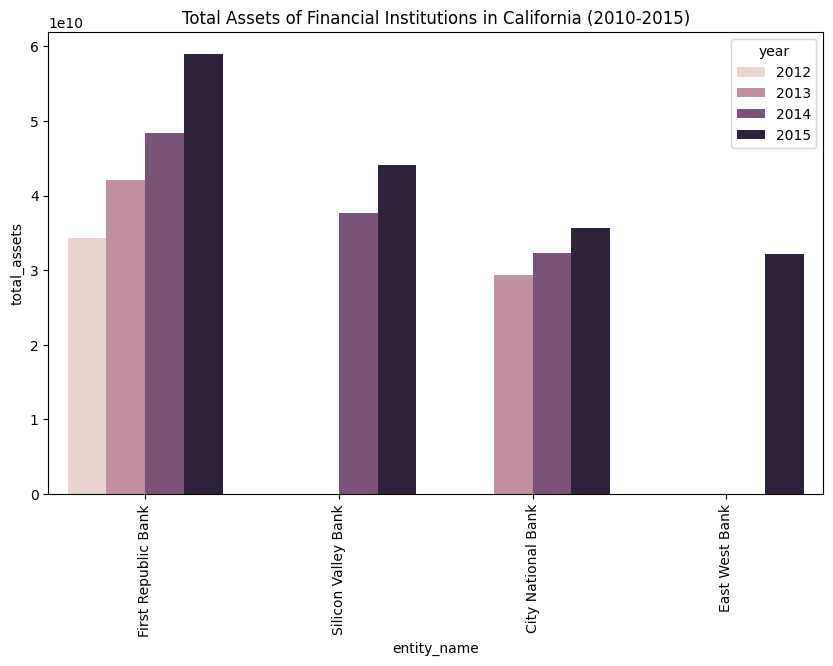

In [397]:
import seaborn as sns
import matplotlib.pyplot as plt

# Check if the dataframe has more than one row
if len(df) > 1:
    plt.figure(figsize=(10,6))
    sns.barplot(x='entity_name', y='total_assets', hue='year', data=df, ci=None)
    plt.xticks(rotation=90)
    plt.title('Total Assets of Financial Institutions in California (2010-2015)')
    plt.show()
else:
    print("Total Assets: ", df['total_assets'].values[0])

In [366]:
response = llm_chain(chat_template.format_messages(user_input=human_input))

In [375]:
print(response["text"])

```python
import plotly.express as px

if len(df['entity_name'].unique()) == 1:
    import plotly.graph_objects as go
    fig = go.Figure(go.Indicator(
        mode = "number",
        value = df['total_assets'].values[0],
        title = {"text": f"Total Assets of {df['entity_name'].values[0]} in {df['year'].values[0]}"}))
else:
    fig = px.bar(df, x='entity_name', y='total_assets', color='year', title='Total Assets of Financial Institutions in California (2010-2015)')
fig.show()
```


In [382]:
import plotly.express as px

if len(df['entity_name'].unique()) == 1:
    print("s")
    import plotly.graph_objects as go
    fig = go.Figure(go.Indicator(
        mode = "number",
        value = df['total_assets'].values[0],
        title = {"text": f"Total Assets of {df['entity_name'].values[0]} in {df['year'].values[0]}"}))
else:
    fig = px.bar(df, x='entity_name', y='total_assets', color='year', title='Total Assets of Financial Institutions in California (2010-2015)')


In [385]:
df

,entity_name,year,total_assets
0,First Republic Bank,2015,5.898128e+10
1,First Republic Bank,2014,4.835333e+10
2,Silicon Valley Bank,2015,4.405524e+10
3,First Republic Bank,2013,4.211276e+10
4,Silicon Valley Bank,2014,3.761962e+10
5,City National Bank,2015,3.571680e+10
6,First Republic Bank,2012,3.438768e+10
7,City National Bank,2014,3.231404e+10
8,East West Bank,2015,3.224378e+10
9,City National Bank,2013,2.937339e+10


In [384]:
df

,entity_name,year,total_assets
0,First Republic Bank,2015,5.898128e+10
1,First Republic Bank,2014,4.835333e+10
2,Silicon Valley Bank,2015,4.405524e+10
3,First Republic Bank,2013,4.211276e+10
4,Silicon Valley Bank,2014,3.761962e+10
5,City National Bank,2015,3.571680e+10
6,First Republic Bank,2012,3.438768e+10
7,City National Bank,2014,3.231404e+10
8,East West Bank,2015,3.224378e+10
9,City National Bank,2013,2.937339e+10


In [354]:
df = pd.read_csv("stored_data/1vszy/azyu6vupzf68m9p.csv")

In [356]:
df.dtypes

entity_name      object
year              int64
total_assets    float64
dtype: object

In [358]:
llm_chat_model

AzureChatOpenAI(client=<class 'openai.api_resources.chat_completion.ChatCompletion'>, model_name='gpt-4-32k', temperature=0.0, openai_api_key='cdf63ece486a426da741e31ef181950c', openai_api_base='https://ai-stage2.openai.azure.com/', openai_proxy='', deployment_name='gpt-4-32k', openai_api_version='2023-08-01-preview', openai_api_type='azure')

### hallucination

In [386]:
run_agent("What was the % change in each real estate loans for banks headquartered in California between 2015 and 2020?")



> Entering new AgentExecutor chain...
Thought: I should look at the tables in the database to see what I can query. Then I should query the schema of the most relevant tables.
Action: sql_db_list_tables
Action Input: ""  llm output
Thought: I should look at the tables in the database to see what I can query. Then I should query the schema of the most relevant tables.
Action: sql_db_list_tables
Action Input: ""

Observation:financial_entity_annual_time_series, financial_entity_attributes_limited
The tables 'financial_entity_annual_time_series' and 'financial_entity_attributes_limited' seem to be relevant. I should check their schemas to see if they contain the necessary information to answer the question.
Action: sql_db_schema
Action Input: financial_entity_annual_time_series, financial_entity_attributes_limited  llm output
The tables 'financial_entity_annual_time_series' and 'financial_entity_attributes_limited' seem to be relevant. I should check their schemas to see if they contain

FileNotFoundError: [Errno 2] No such file or directory: 'stored_data/1234567890.csv'

In [ ]:
run_agent("What was the % change in each real estate loans for banks headquartered in California between 2015 and 2020?")